In [1]:
# import 
import os
import re
import csv
import copy
import time
import math
from math import sqrt, acos, atan2, sin, cos
import datetime
import statistics
import neurokit2 as nk

from numpy import dot
from numpy.linalg import norm
import numpy as np
import pandas as pd
from pandas import ExcelWriter 
from glob import glob
from collections import defaultdict
import pingouin as pg
import scipy.stats as stats
import scipy
import pickle
import pymannkendall as mk
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno
%load_ext line_profiler

from src.utils import (
    createDir, time2frame, metadata2frame, coughxlsx2df, processed2df, cut2case, cut2single, 
    _make_query, make_queries, query, query_w, getqueries, tval_df, bubbles2e, openpkl,
    createFolder, data2csv, save2pkl
)

from src.utils_plot import(
    cutplot, draw_corr_pval, drawheatmap_ttest,
)

import Dataloader as dl

c:\Users\user\anaconda3\envs\torch\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:

# datapath_top = f'./data/raw/{date}'
datapath_top = f"./testdata"
scenes = ["Practice", "Elvtest", "Outside", "Hallway", "Elevator", "Hall"]

(names, anxiety, unity) = dl.dataloader(datapath_top, scenes)
# names: list  ## Participant name list
## anxiety dict_keys(['Psychopy', 'Survey', 'VR'])
# anxiety['VR'][0][0] : dataframe ## Physiological data, VR experiment
# anxiety['VR'][0][1] ## Physiological data, VR experiment , metadata
# anxiety['Psychopy'] : list ## list of psychopy data file adress
# anxiety['Survey'][0][0] : list : dataframe ## Physiological data, Psychopy video survey

## unity dict_keys(['customevent', 'lifecycleevent', 'position', 'rotation', 'subjectmetadata', 'subjects'])
# unity: dictionary ## Unity Behavioral data unity[datatype(ex-customevent)][scenename]

Stream 1: Calculated effective sampling rate 255.9682 Hz is different from specified rate 100.0000 Hz.


1


Stream 1: Calculated effective sampling rate 255.9682 Hz is different from specified rate 100.0000 Hz.
Stream 1: Calculated effective sampling rate 256.0269 Hz is different from specified rate 100.0000 Hz.


3


Stream 1: Calculated effective sampling rate 256.0269 Hz is different from specified rate 100.0000 Hz.


4


Stream 1: Calculated effective sampling rate 255.9896 Hz is different from specified rate 100.0000 Hz.
Stream 1: Calculated effective sampling rate 255.9896 Hz is different from specified rate 100.0000 Hz.


5


Stream 1: Calculated effective sampling rate 256.0052 Hz is different from specified rate 100.0000 Hz.
Stream 1: Calculated effective sampling rate 256.0052 Hz is different from specified rate 100.0000 Hz.
Stream 1: Calculated effective sampling rate 256.0057 Hz is different from specified rate 100.0000 Hz.


6


Stream 1: Calculated effective sampling rate 256.0057 Hz is different from specified rate 100.0000 Hz.


7


Stream 1: Calculated effective sampling rate 256.0060 Hz is different from specified rate 100.0000 Hz.
Stream 1: Calculated effective sampling rate 256.0060 Hz is different from specified rate 100.0000 Hz.


In [3]:
anxiety_psy = []
scenes = ["breath", "base1", "stimuli", "base2"]
_anxiety, scenes = anxiety['Psychopy'],scenes
for infile in _anxiety:
    name = infile.split("\\")[1]
    lst = []
    with open(infile,encoding="ISO-8859-1") as f:
        f = f.readlines()
        
    for lines in f:
        lst.append(re.split(" \t|: | = |\n", lines))


    anxiety_df = pd.DataFrame(lst, columns=['Time', '1', 'video', 'type', 'marker', 'drop'])
    anxiety_df = anxiety_df[anxiety_df['1'] == "EXP"]    
    anxiety_df = anxiety_df.drop(["1","drop"], axis=1)
    anxiety_df["Scene"] = 0

    for idx in range(len(scenes)):
        midx = idx + 1 
        start = anxiety_df[(anxiety_df['video'] == f"movie{midx}")&(anxiety_df['type'] == "autoDraw")&(anxiety_df['marker'] == "True")].index[0]
        end = anxiety_df[(anxiety_df['video'] == f"movie{midx}")&(anxiety_df['type'] == "autoDraw")&(anxiety_df['marker'] == "False")].index[0]
        anxiety_df.loc[start:end+1, "Scene"] = scenes[idx] 
        
    anxiety_df = anxiety_df[anxiety_df['Scene'] != 0].reset_index(drop=True)
    
    for scene in scenes:
        _df = anxiety_df[anxiety_df["Scene"] == scene]
        first = anxiety_df[anxiety_df["Scene"] == scene].index[0]
        last = anxiety_df[anxiety_df["Scene"] == scene].index[-1]
        startval = _df.loc[first+2,"marker"]
        endval = _df.loc[last-3,"marker"]
        
        anxiety_df.loc[first:first+2,"marker"] = startval
        anxiety_df.loc[last-2:last,"marker"] = endval  
        
    anxiety_df = anxiety_df.drop(["video","type"], axis=1)
    anxiety_df["Subject"] = name
    # anxiety_df[["Time", "marker"]] = anxiety_df[["Time", "marker"]].astype("float64")
    # anxiety_df["marker"] = np.clip(anxiety_df["marker"],1,5)
    anxiety_psy.append(anxiety_df)
    
# directory = f'./testdata/processed'
# data2csv(anxiety_psy, names, filename='Anxiety_psychopy',directory=directory)

Slider_x  Timestamp_x  Timestamp_RAW  Timestamp_CAL  \
1970-01-01 00:00:00.000       NaN          NaN      4266487.0     590828.125   
1970-01-01 00:00:00.005       NaN          NaN      4266651.0     590833.125   
1970-01-01 00:00:00.010       NaN          NaN      4266814.5     590838.125   
1970-01-01 00:00:00.015       NaN          NaN      4266978.5     590843.125   
1970-01-01 00:00:00.020       NaN          NaN      4267142.5     590848.125   
...                           ...          ...            ...            ...   
1970-01-01 00:02:23.980     100.0    30.154442      8985120.0     734829.375   
1970-01-01 00:02:23.985     100.0    30.154442      8985283.0     734834.375   
1970-01-01 00:02:23.990     100.0    30.154442      8985447.0     734839.375   
1970-01-01 00:02:23.995     100.0    30.154442      8985611.0     734844.375   
1970-01-01 00:02:24.000     100.0    30.154442      8985775.0     734849.375   

                         System Timestamp_CAL  Low Noise Accelerometer X_RAW  \
1970-01-01 00:00:00.000          1.723797e+12                    1954.000000   
1970-01-01 00:00:00.005          1.723797e+12                    1954.719849   
1970-01-01 00:00:00.010          1.723797e+12                    1953.439575   
1970-01-01 00:00:00.015          1.723797e+12                    1953.840576   
1970-01-01 00:00:00.020          1.723797e+12                    1955.000000   
...                                       ...                            ...   
1970-01-01 00:02:23.980          1.723797e+12                    1955.317383   
1970-01-01 00:02:23.985          1.723797e+12                    1955.402466   
1970-01-01 00:02:23.990          1.723797e+12                    1955.877808   
1970-01-01 00:02:23.995          1.723797e+12                    1955.157959   
1970-01-01 00:02:24.000          1.723797e+12                    1955.123779   

                         Low Noise Accelerometer X_CAL  \
1970-01-01 00:00:00.000                       1.530120   
1970-01-01 00:00:00.005                       1.514696   
1970-01-01 00:00:00.010                       1.512776   
1970-01-01 00:00:00.015                       1.538327   
1970-01-01 00:00:00.020                       1.506024   
...                                                ...   
1970-01-01 00:02:23.980                       1.466056   
1970-01-01 00:02:23.985                       1.472231   
1970-01-01 00:02:23.990                       1.460777   
1970-01-01 00:02:23.995                       1.443880   
1970-01-01 00:02:24.000                       1.439014   

                         Low Noise Accelerometer Y_RAW  \
1970-01-01 00:00:00.000                    1920.000000   
1970-01-01 00:00:00.005                    1921.280151   
1970-01-01 00:00:00.010                    1921.439575   
1970-01-01 00:00:00.015                    1919.318848   
1970-01-01 00:00:00.020                    1922.000000   
...                                                ...   
1970-01-01 00:02:23.980                    1925.317383   
1970-01-01 00:02:23.985                    1924.804810   
1970-01-01 00:02:23.990                    1925.755493   
1970-01-01 00:02:23.995                    1927.157959   
1970-01-01 00:02:24.000                    1927.561890   

                         Low Noise Accelerometer Y_CAL  \
1970-01-01 00:00:00.000                       1.120482   
1970-01-01 00:00:00.005                       1.111809   
1970-01-01 00:00:00.010                       1.127234   
1970-01-01 00:00:00.015                       1.122403   
1970-01-01 00:00:00.020                       1.108434   
...                                                ...   
1970-01-01 00:02:23.980                       1.104610   
1970-01-01 00:02:23.985                       1.103585   
1970-01-01 00:02:23.990                       1.097858   
1970-01-01 00:02:23.995                       1.106531   
1970-01-01 00:02:24.000                       1.106943   

            

In [91]:
scenes = ["breath", "base1", "stimuli", "base2"]
tests = []
for trial in range(len(names)):
    df = anxiety['test'][trial][0].copy()
    df = df.dropna().reset_index(drop=True)
    if 'Timestamp_y' in df.columns:
        df = df.rename(columns={'Timestamp_y':'Timestamp'})
    min_t = df['Timestamp_RAW'].min()
    df['Timestamp_RAW'] = df['Timestamp_RAW'] - min_t

    eda =nk.eda_process(df["GSR_CAL"], sampling_rate=100)[0].reset_index()
    ppg = nk.ppg_process(df["Internal ADC A13_CAL"], sampling_rate=100)[0].reset_index()
    _df = df['Timestamp'].reset_index().copy()
    _df = pd.merge(left = _df, right = eda, how="outer", sort= True) 
    _df = pd.merge(left = _df, right = ppg, how="outer", sort= True)
    # _df['Timestamp'] = _df['Timestamp'].apply(time2frame, textformet=False, frame=50) ## 초당 frame 50
    _df['Timestamp'] = _df['Timestamp'].apply(time2frame, textformet=False, frame=100) ## 초당 frame 50
    
    ## Get each scene pass
    lst = [0]
    previous = 0
    # for i in list(_df[_df['Timestamp']==1].index):
    for i in list(_df[_df['Timestamp']==2].index):
        if i - previous > 1:
            lst.append(i)
        previous = i
    lst.append(len(_df)-1)
    _df['Scene'] = 0
    for idx in range(len(scenes)):
        st = lst[idx]
        ed = lst[idx+1]
        _df.loc[st:ed, 'Scene'] = scenes[idx]
    whole_df = pd.DataFrame()
    for scene in scenes:
        _df_ = _df[_df['Scene']==scene].groupby('Timestamp')[['EDA_Raw', 'EDA_Clean', 'EDA_Tonic', 'EDA_Phasic',
        'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
        'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime', 'PPG_Raw',
        'PPG_Clean', 'PPG_Rate', 'PPG_Peaks']].mean()
        _df_['Scene'] = scene
        
        whole_df = pd.concat([whole_df, _df_])
    whole_df = whole_df.reset_index()
    whole_df['Trial'] = names[trial]
    tests.append(whole_df)
total_df = pd.DataFrame()
for data in tests:
    total_df = pd.concat([total_df, data])

total_df = total_df.reset_index()


In [95]:
total_df

index  Timestamp     EDA_Raw   EDA_Clean   EDA_Tonic  EDA_Phasic  \
0           0          1   86.278717   86.268921   87.973386   -1.704465   
1           1          2   86.467560   86.500626   87.259825   -0.759199   
2           2          3   86.499229   86.504660   87.265873   -0.761213   
3           3          4   86.517227   86.509217   87.271943   -0.762726   
4           4          5   86.499229   86.514523   87.278036   -0.763513   
...       ...        ...         ...         ...         ...         ...   
167240  35581       3009  116.100342  116.077443  115.139120   -1.077425   
167241  35582       3010  116.107529  116.078200  115.139117   -1.049767   
167242  35583       3011  116.075554  116.078557  115.139091   -1.022169   
167243  35584       3012  116.100327  116.078445  115.139043   -0.994698   
167244  35585       3013  112.536346  112.534504  115.001372    4.125790   

        SCR_Onsets  SCR_Peaks  SCR_Height  SCR_Amplitude  SCR_RiseTime  \
0              0.0   0.000000    0.000000       0.000000      0.000000   
1              0.0   0.000000    0.000000       0.000000      0.000000   
2              0.0   0.000000    0.000000       0.000000      0.000000   
3              0.0   0.000000    0.000000       0.000000      0.000000   
4              0.0   0.000000    0.000000       0.000000      0.000000   
...            ...        ...         ...            ...           ...   
167240         0.0   0.000000    0.000000       0.000000      0.000000   
167241         0.0   0.000000    0.000000       0.000000      0.000000   
167242         0.0   0.000000    0.000000       0.000000      0.000000   
167243         0.0   0.000000    0.000000       0.000000      0.000000   
167244         0.0   0.001931    0.017687       0.023266      0.013166   

        SCR_Recovery  SCR_RecoveryTime      PPG_Raw   PPG_Clean   PPG_Rate  \
0           0.000000          0.000000  1601.968262  104.790281  39.848481   
1           0.000000          0.000000  1435.991211  -36.718870  41.220570   
2           0.000000          0.000000  1435.978638  -37.599460  41.220570   
3           0.000000          0.000000  1438.239258  -38.459668  41.220570   
4           0.000000          0.000000  1441.725952  -39.180322  41.220570   
...              ...               ...          ...         ...        ...   
167240      0.000000          0.000000  1558.822266   43.725408  41.698857   
167241      0.000000          0.000000  1534.699219   19.178223  41.706807   
167242      0.000000          0.000000  1511.527100   -2.855646  41.715557   
167243      0.000000          0.000000  1490.827271  -22.504751  41.725085   
167244      0.001931          0.002046  1517.391724   -3.744267  66.861040   

        PPG_Peaks   Scene Trial  
0        0.000000  breath     1  
1        0.000000  breath     1  
2        0.000000  breath     1  
3        0.000000  breath     1  
4        0.000000  breath     1  
...           ...     ...   ...  
167240   0.000000   base2     7  
167241   0.000000   base2     7  
167242   0.000000   base2     7  
167243   0.000000   base2     7  
167244   0.009653   base2     7  

[167245 rows x 19 columns]

In [92]:
# _df[_df['Scene']=='breath']
# _df[_df['Scene']=='base1']
_df[_df['Scene']=='base2']
# _df[_df['Scene']=='breath']


index  Timestamp     EDA_Raw   EDA_Clean   EDA_Tonic  EDA_Phasic  \
65150  65150          2  138.738205  138.838843  138.617133    0.221699   
65151  65151          2  138.768188  138.843973  138.605636    0.238326   
65152  65152          3  138.969498  138.848910  138.594095    0.254803   
65153  65153          3  138.868011  138.853642  138.582509    0.271122   
65154  65154          4  138.694427  138.858166  138.570880    0.287275   
...      ...        ...         ...         ...         ...         ...   
71685  71685       3013   94.775948   94.690020  114.876309    0.602857   
71686  71686       3013   94.595650   94.560382  114.876300    0.555359   
71687  71687       3013   94.461975   94.442103  114.876292    0.519379   
71688  71688       3013   94.257851   94.335760  114.876285    0.495491   
71689  71689       3013   94.068161   94.241694  114.876279    0.484039   

       SCR_Onsets  SCR_Peaks  SCR_Height  SCR_Amplitude  SCR_RiseTime  \
65150           0          0         0.0            0.0           0.0   
65151           0          0         0.0            0.0           0.0   
65152           0          0         0.0            0.0           0.0   
65153           0          0         0.0            0.0           0.0   
65154           0          0         0.0            0.0           0.0   
...           ...        ...         ...            ...           ...   
71685           0          0         0.0            0.0           0.0   
71686           0          0         0.0            0.0           0.0   
71687           0          0         0.0            0.0           0.0   
71688           0          0         0.0            0.0           0.0   
71689           0          0         0.0            0.0           0.0   

       SCR_Recovery  SCR_RecoveryTime      PPG_Raw   PPG_Clean    PPG_Rate  \
65150             0               0.0  1418.058350  -98.748623   42.660865   
65151             0               0.0  1417.582397 -100.389773   42.656979   
65152             0               0.0  1415.729370 -101.853832   42.653152   
65153             0               0.0  1414.962036 -103.087883   42.649386   
65154             0               0.0  1413.186768 -104.039649   42.645680   
...             ...               ...          ...         ...         ...   
71685             0               0.0  1758.835815   84.668228  107.142857   
71686             0               0.0  1755.378052   74.272831  107.142857   
71687             0               0.0  1753.053589   61.709840  107.142857   
71688             0               0.0  1745.123291   47.512024  107.142857   
71689             0               0.0  1736.768066   32.339905  107.142857   

       PPG_Peaks  Scene  
65150          0  base2  
65151          0  base2  
65152          0  base2  
65153          0  base2  
65154          0  base2  
...          ...    ...  
71685          0  base2  
71686          0  base2  
71687          0  base2  
71688          0  base2  
71689          0  base2  

[6540 rows x 18 columns]

In [93]:
_df['Scene'].unique()

array(['breath', 'base1', 'stimuli', 'base2'], dtype=object)

In [56]:
df

Timestamp_RAW  Timestamp_CAL  System Timestamp_CAL  \
0               0.00   67384.289062          1.723797e+12   
1             163.75   67389.289062          1.723797e+12   
2             327.75   67394.289062          1.723797e+12   
3             491.50   67399.289062          1.723797e+12   
4             655.25   67404.289062          1.723797e+12   
...              ...            ...                   ...   
39953     6545274.50  267130.218750          1.723797e+12   
39954     6545438.50  267135.218750          1.723797e+12   
39955     6545602.50  267140.218750          1.723797e+12   
39956     6545766.50  267145.218750          1.723797e+12   
39957     6545930.50  267150.218750          1.723797e+12   

       Low Noise Accelerometer X_RAW  Low Noise Accelerometer X_CAL  \
0                        1979.863403                       1.573748   
1                        1978.658691                       1.574202   
2                        1979.000000                       1.589622   
3                        1978.781494                       1.585096   
4                        1977.501587                       1.578274   
...                              ...                            ...   
39953                    1967.339111                       1.510110   
39954                    1968.619019                       1.503155   
39955                    1967.202148                       1.504806   
39956                    1969.821167                       1.493976   
39957                    1968.541260                       1.499502   

       Low Noise Accelerometer Y_RAW  Low Noise Accelerometer Y_CAL  \
0                        1916.378906                       0.808875   
1                        1916.341309                       0.823389   
2                        1915.061401                       0.819277   
3                        1915.437012                       0.821910   
4                        1916.003174                       0.837330   
...                              ...                            ...   
39953                    1921.660889                       0.959769   
39954                    1922.238037                       0.944349   
39955                    1922.101074                       0.961420   
39956                    1923.000000                       0.929865   
39957                    1922.541260                       0.945285   

       Low Noise Accelerometer Z_RAW  Low Noise Accelerometer Z_CAL  \
0                        1243.378906                       9.682182   
1                        1243.341309                       9.682635   
2                        1243.000000                       9.686747   
3                        1244.000000                       9.674699   
4                        1243.501587                       9.680703   
...                              ...                            ...   
39953                    1244.339111                       9.670612   
39954                    1244.380981                       9.670109   
39955                    1244.000000                       9.674699   
39956                    1245.000000                       9.662651   
39957                    1244.082642                       9.673703   

       Gyroscope X_RAW  ...  Internal ADC A13_CAL  Pressure_RAW  Pressure_CAL  \
0           -75.105637  ...           1433.067139  39206.000000    100.111122   
1           -65.412491  ...           1435.397461  39206.000000    100.111122   
2           -56.368225  ...           1436.585083  39206.000000    100.111122   
3           -73.151627  ...           1436.057495  39206.000000    100.111122   
4           -83.514542  ...           1435.899780  39206.000000    100.111122   
...                ...  ...                   ...           ...           ...   
39953       -72.713348  ...           1559.891357  39170.339844    100.109818   
39954       -77.380951  ...           1549.938965  39171.000000    

In [32]:
total_df[total_df['Trial']==]

index  Timestamp    EDA_Raw  EDA_Clean  EDA_Tonic  EDA_Phasic  \
0         0          1  86.483398  86.500662  87.259828   -0.759166   
1         1          2  86.508224  86.509311  87.271946   -0.762635   
2         2          3  86.513962  86.520928  87.284155   -0.763227   
3         3          4  86.534775  86.537060  87.296453   -0.759393   
4         4          5  86.567215  86.558979  87.308842   -0.749863   
...     ...        ...        ...        ...        ...         ...   
9885   9885       1502  83.193092  83.193793  83.228852   -0.387258   
9886   9886       1503  83.200508  83.202330  83.234091   -0.388854   
9887   9887       1504  83.209549  83.211207  83.239270   -0.390081   
9888   9888       1505  83.229034  83.220355  83.244390   -0.391008   
9889   9889       1506  84.200279  84.199981  83.400052    0.147241   

      SCR_Onsets  SCR_Peaks  SCR_Height  SCR_Amplitude  SCR_RiseTime  \
0            0.0        0.0         0.0            0.0           0.0   
1            0.0        0.0         0.0            0.0           0.0   
2            0.0        0.0         0.0            0.0           0.0   
3            0.0        0.0         0.0            0.0           0.0   
4            0.0        0.0         0.0            0.0           0.0   
...          ...        ...         ...            ...           ...   
9885         0.0        0.0         0.0            0.0           0.0   
9886         0.0        0.0         0.0            0.0           0.0   
9887         0.0        0.0         0.0            0.0           0.0   
9888         0.0        0.0         0.0            0.0           0.0   
9889         0.0        0.0         0.0            0.0           0.0   

      SCR_Recovery  SCR_RecoveryTime      PPG_Raw  PPG_Clean   PPG_Rate  \
0              0.0               0.0  1435.276855 -36.725412  41.220570   
1              0.0               0.0  1438.291626 -38.442091  41.220570   
2              0.0               0.0  1442.802368 -39.592246  41.220570   
3              0.0               0.0  1448.883545 -39.413366  41.220570   
4              0.0               0.0  1455.071167 -38.573067  41.220570   
...            ...               ...          ...        ...        ...   
9885           0.0               0.0  1455.035522 -34.781113  36.155282   
9886           0.0               0.0  1440.055664 -48.345929  36.136861   
9887           0.0               0.0  1433.511475 -54.888041  36.118959   
9888           0.0               0.0  1436.961426 -51.464149  36.101616   
9889           0.0               0.0  1512.392456   0.016990  54.946386   

      PPG_Peaks   Scene Trial  
0      0.000000  breath     1  
1      0.000000  breath     1  
2      0.000000  breath     1  
3      0.000000  breath     1  
4      0.000000  breath     1  
...         ...     ...   ...  
9885   0.000000   base2     1  
9886   0.000000   base2     1  
9887   0.000000   base2     1  
9888   0.000000   base2     1  
9889   0.009877   base2     1  

[9890 rows x 19 columns]

In [35]:
df = nk.ppg_analyze(total_df)

In [36]:
df.columns

Index(['PPG_Rate_Mean', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1',
       'HRV_SDANN2', 'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD',
       'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN',
       'HRV_MCVNN', 'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN',
       'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI',
       'HRV_TINN', 'HRV_ULF', 'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF',
       'HRV_TP', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HRV_SD1',
       'HRV_SD2', 'HRV_SD1SD2', 'HRV_S', 'HRV_CSI', 'HRV_CVI',
       'HRV_CSI_Modified', 'HRV_PIP', 'HRV_IALS', 'HRV_PSS', 'HRV_PAS',
       'HRV_GI', 'HRV_SI', 'HRV_AI', 'HRV_PI', 'HRV_C1d', 'HRV_C1a',
       'HRV_SD1d', 'HRV_SD1a', 'HRV_C2d', 'HRV_C2a', 'HRV_SD2d', 'HRV_SD2a',
       'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd', 'HRV_SDNNa', 'HRV_DFA_alpha1',
       'HRV_MFDFA_alpha1_Width', 'HRV_MFDFA_alpha1_Peak',
       'HRV_MFDFA_alpha1_Mean', 'HRV_MFDFA_alpha1_Max',
       'HRV_MF

C:\Users\user\AppData\Local\Temp\ipykernel_3252\3732893696.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,5))


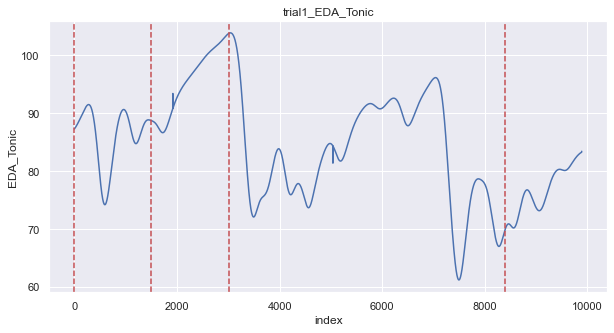

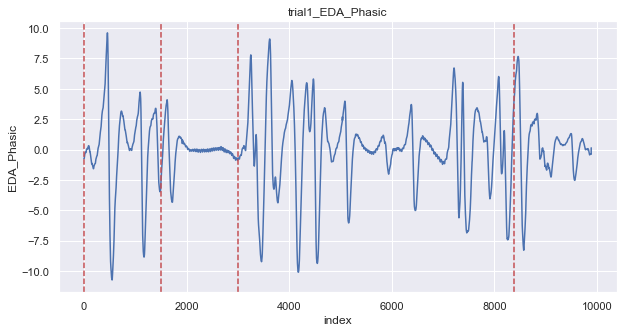

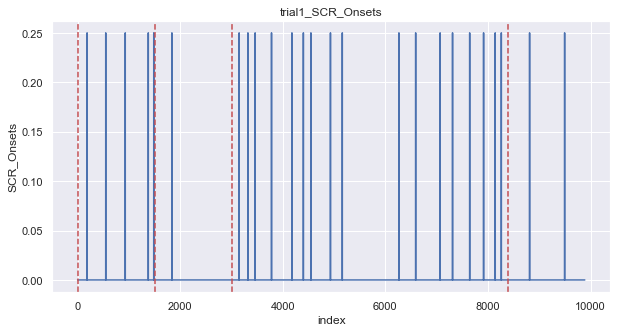

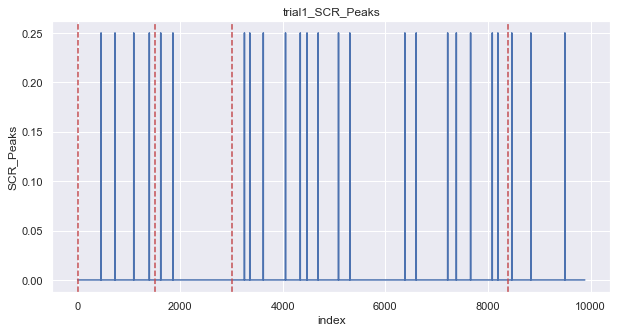

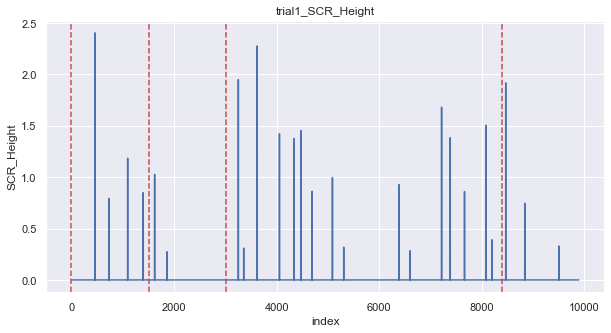

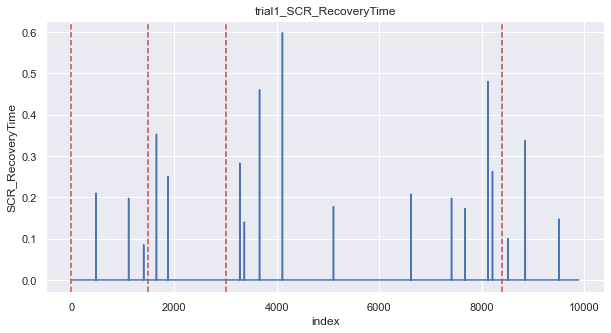

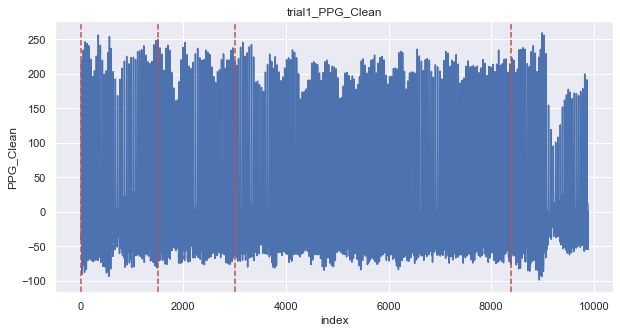

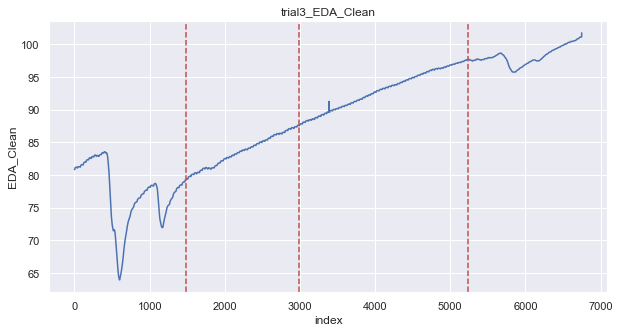

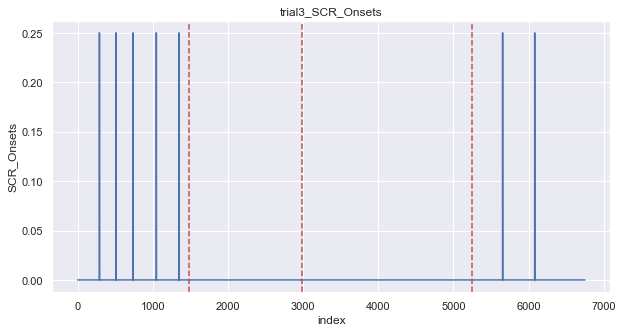

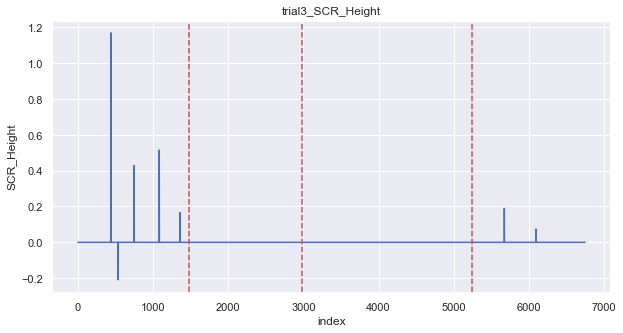

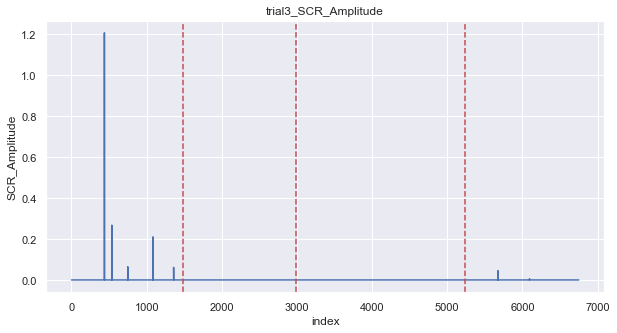

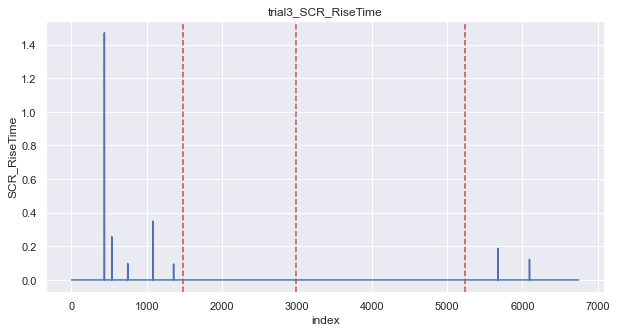

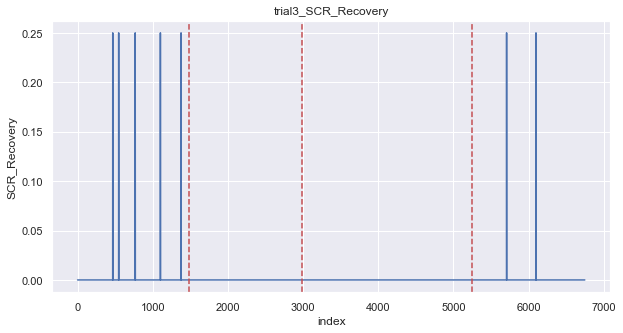

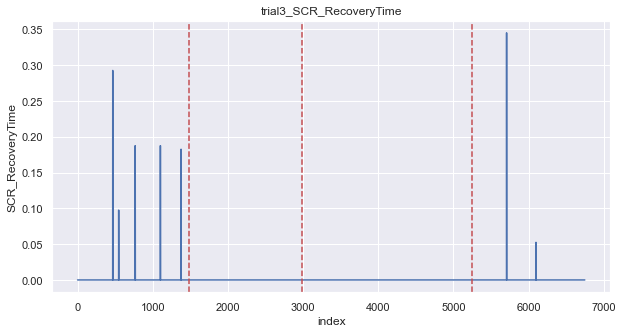

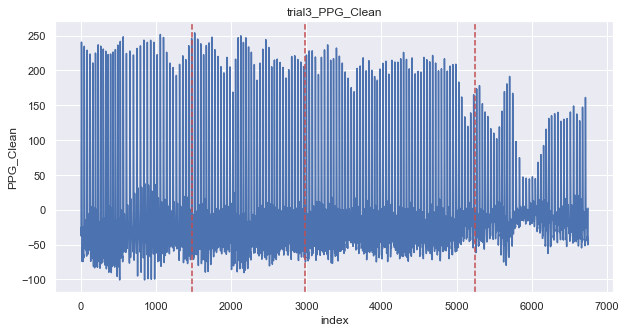

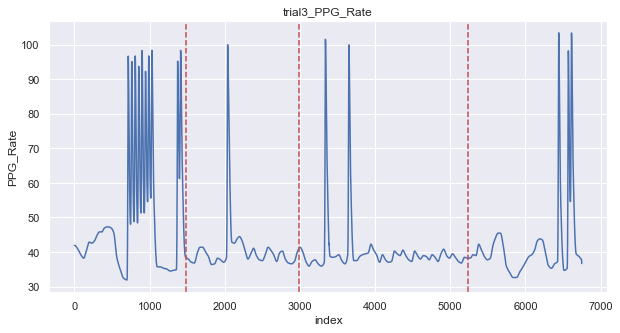

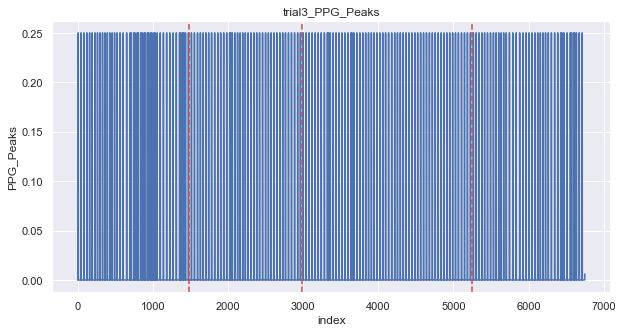

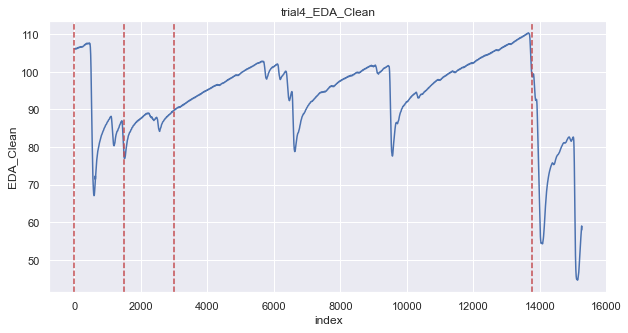

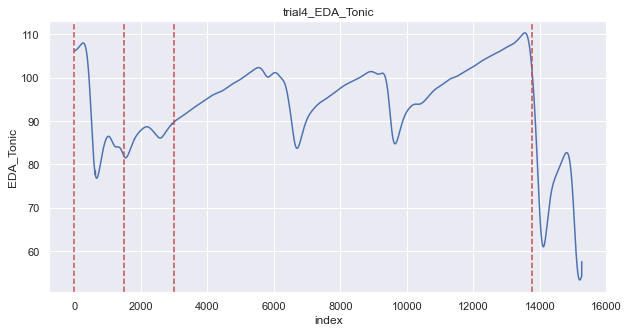

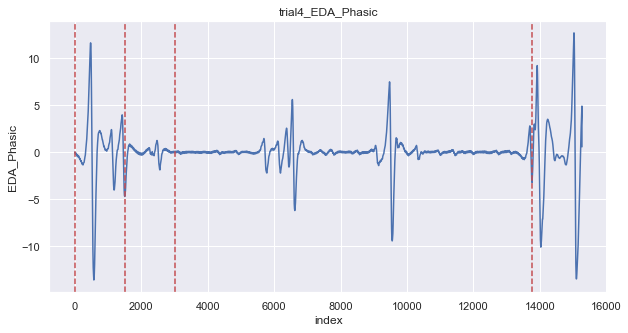

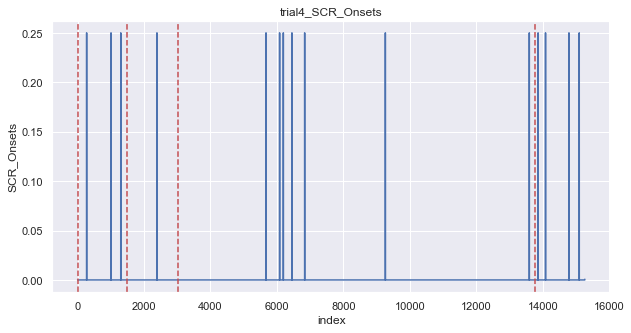

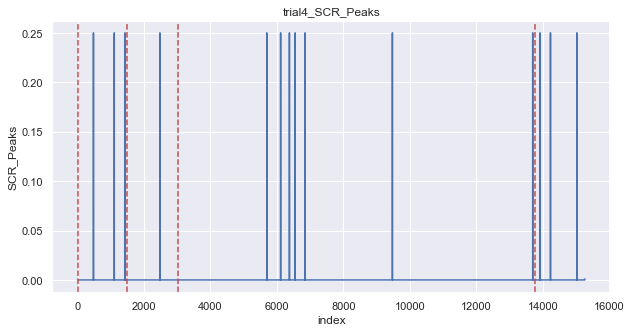

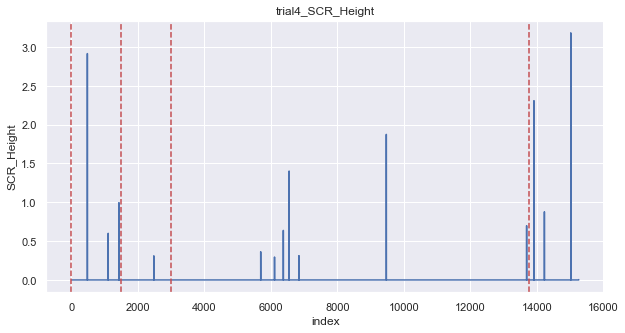

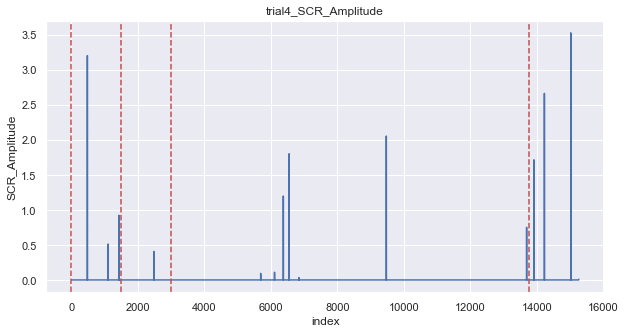

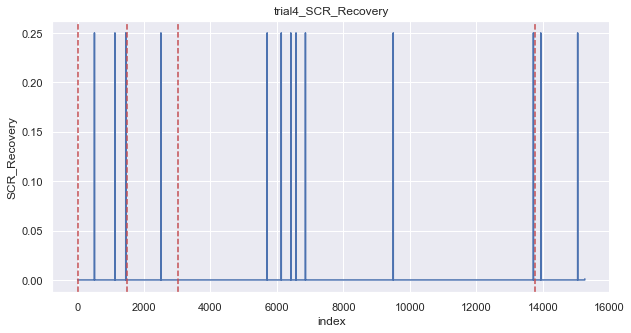

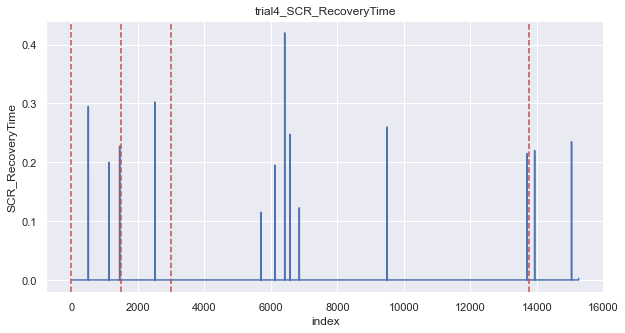

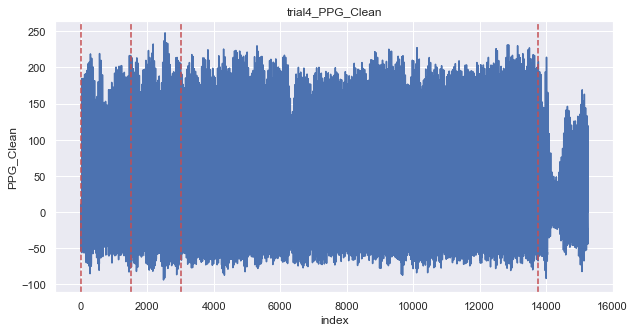

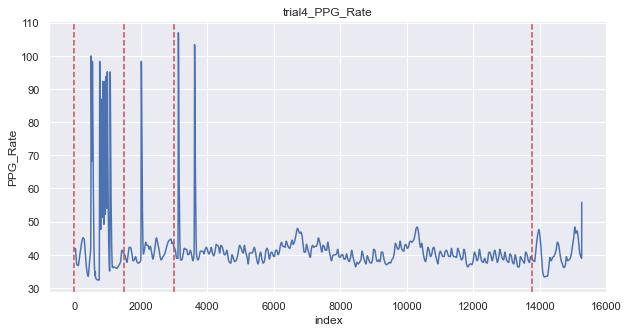

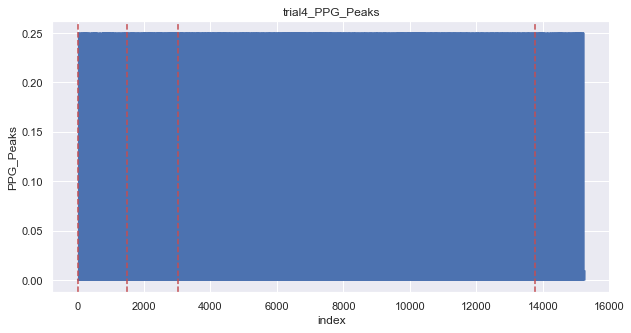

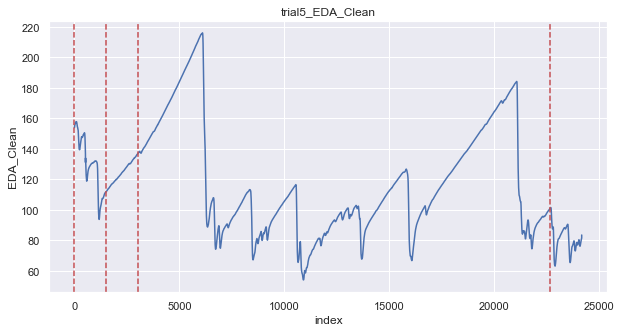

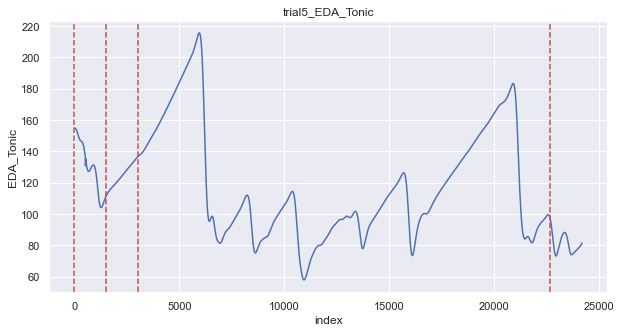

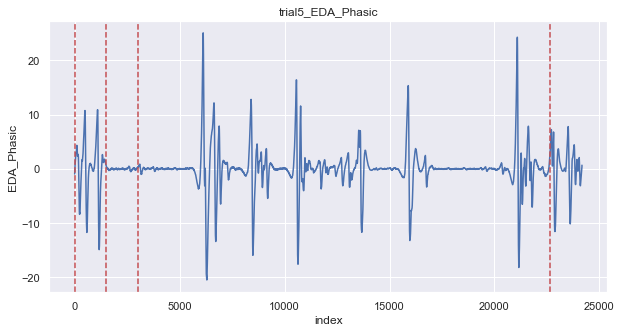

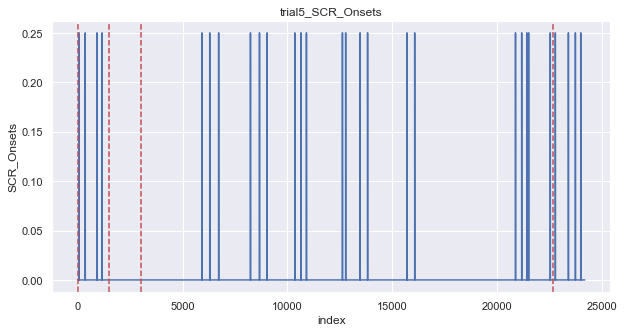

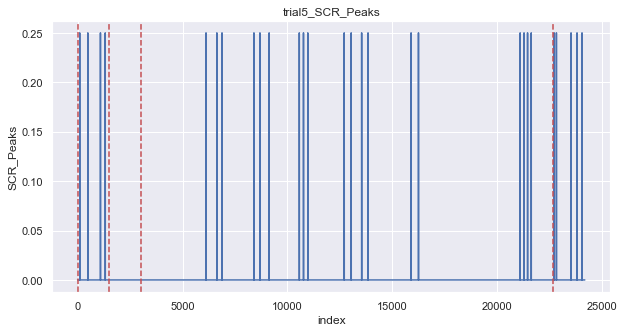

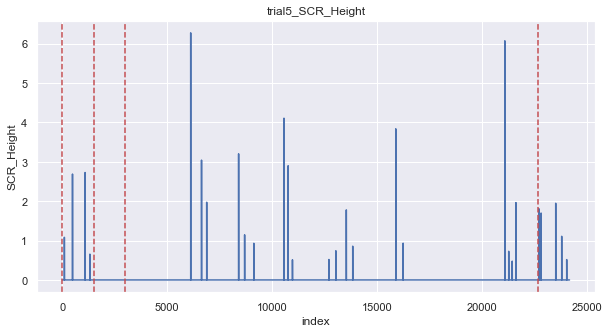

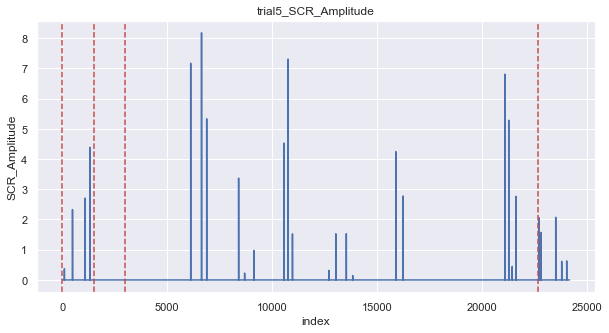

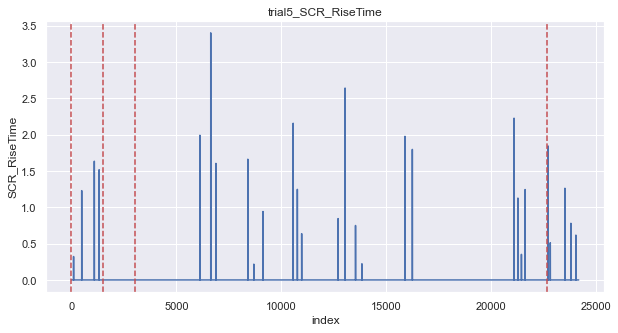

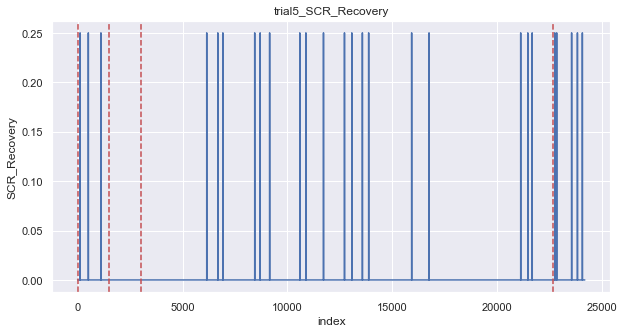

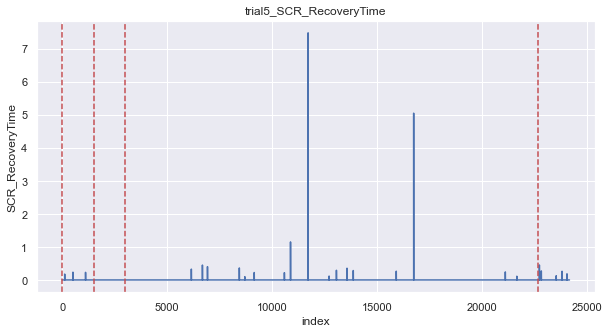

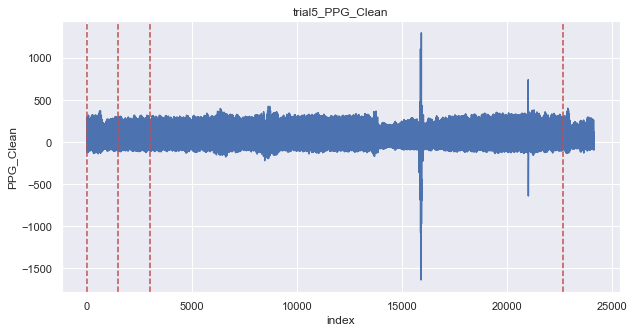

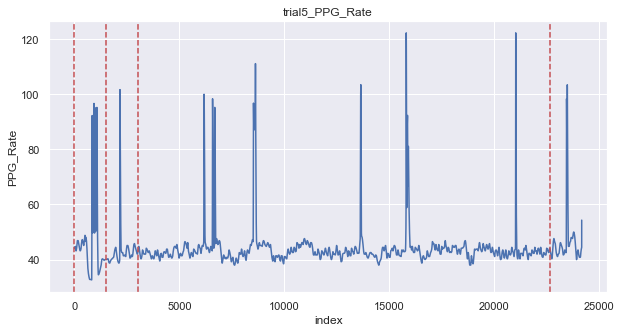

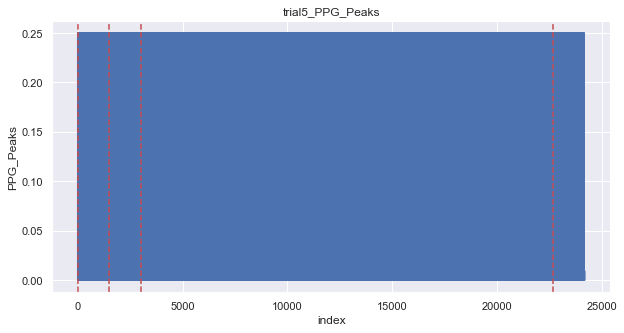

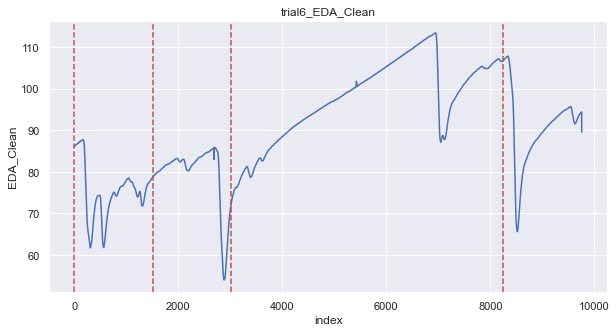

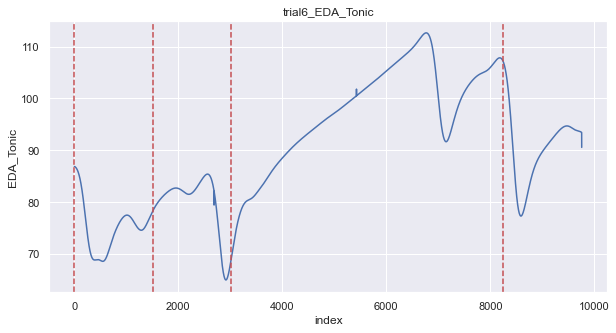

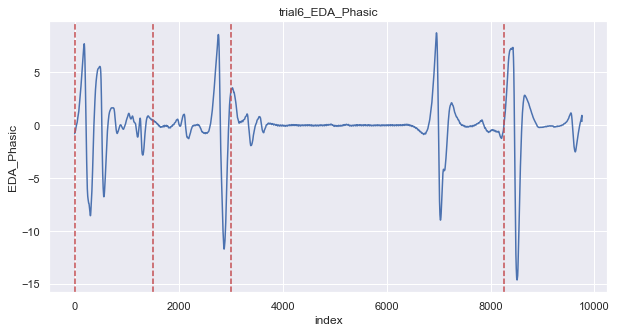

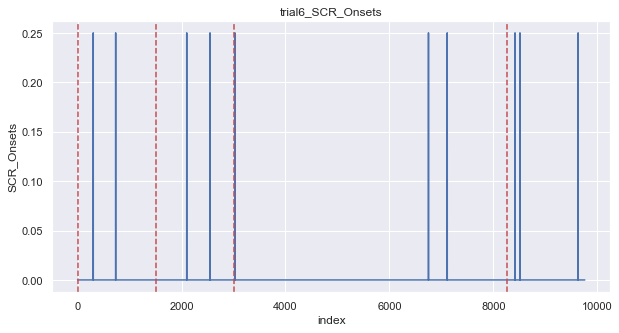

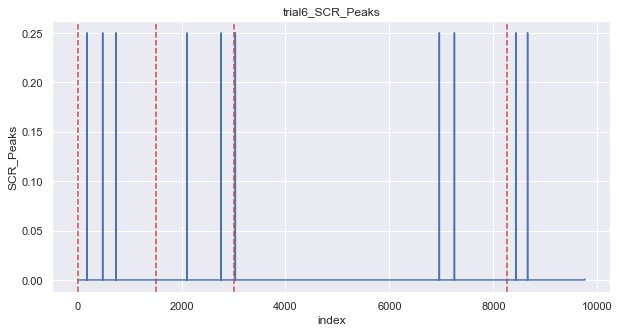

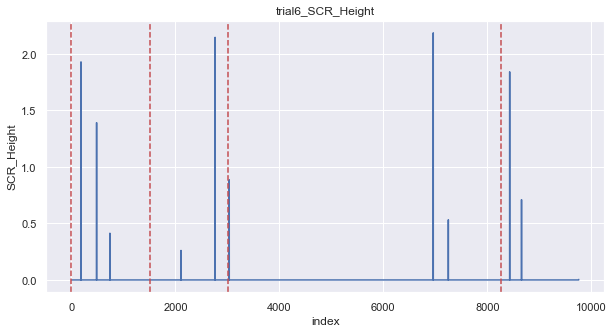

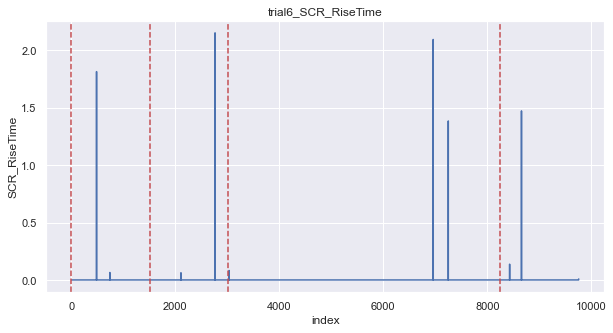

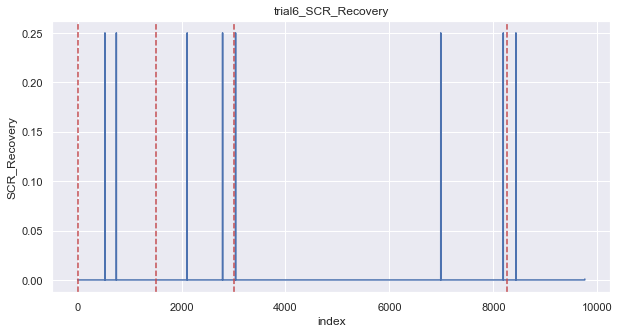

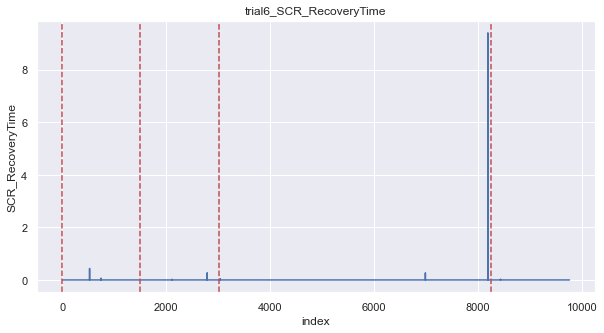

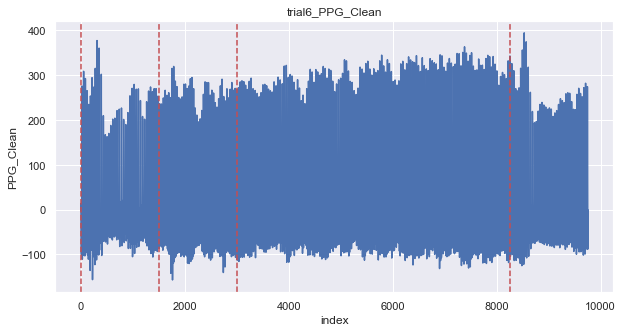

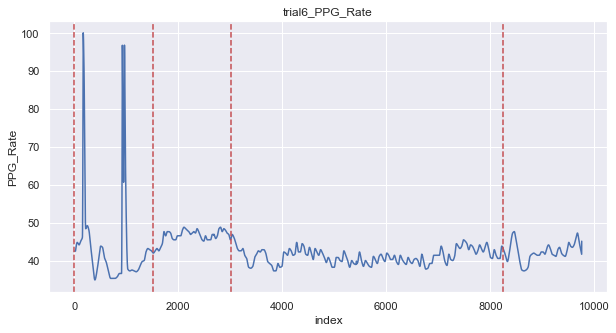

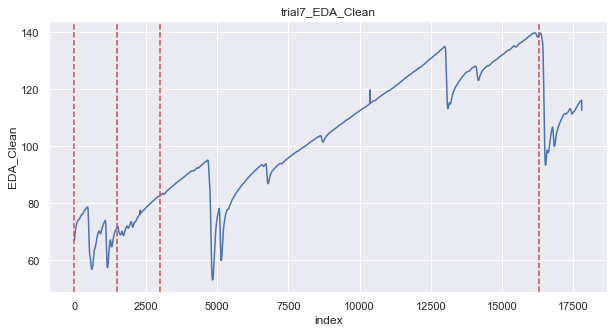

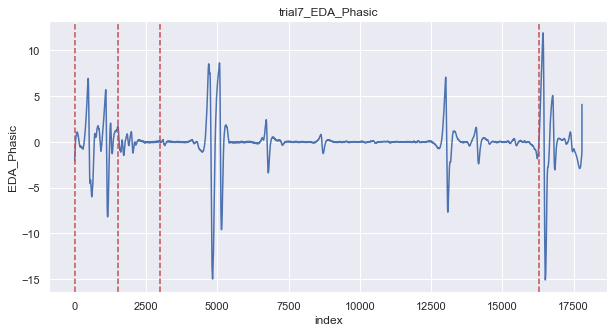

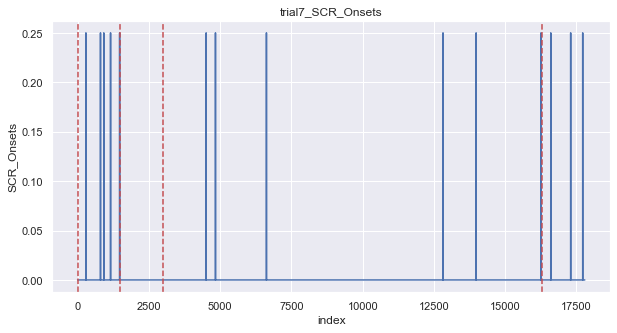

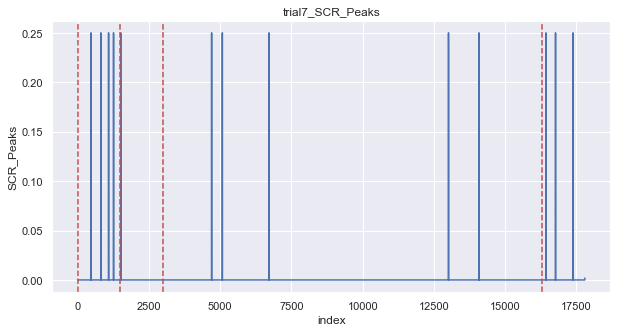

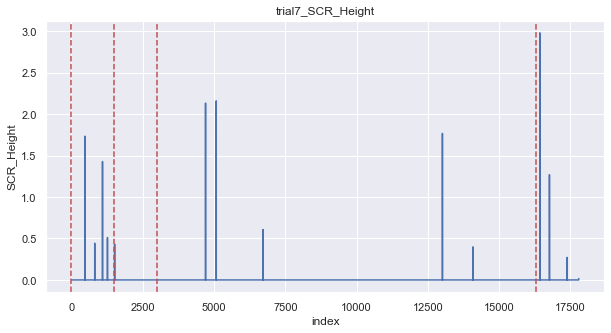

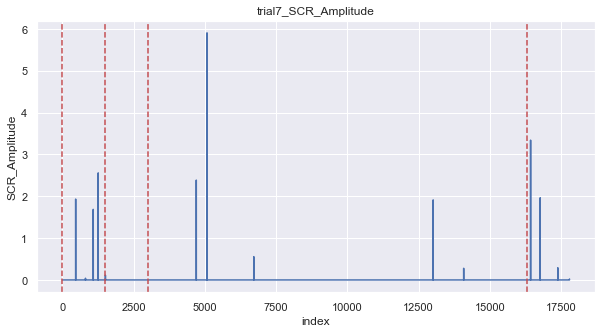

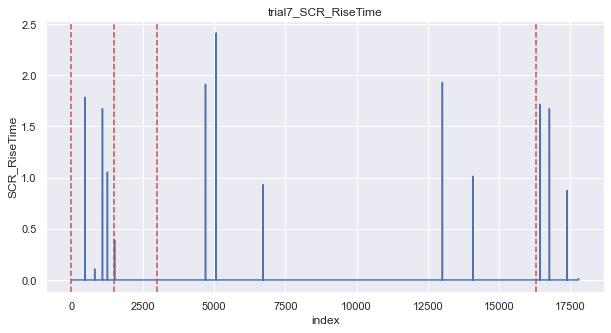

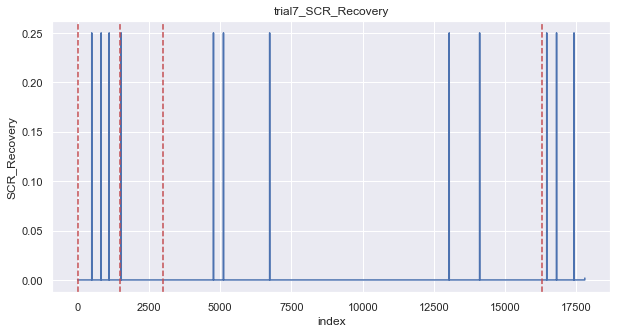

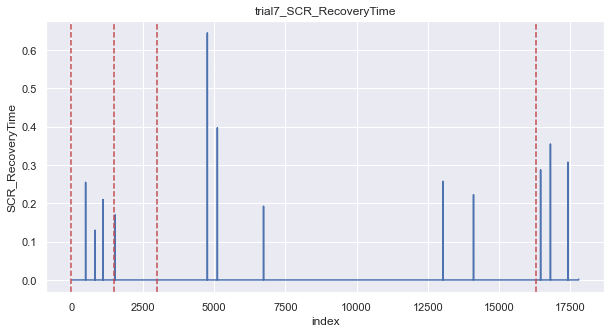

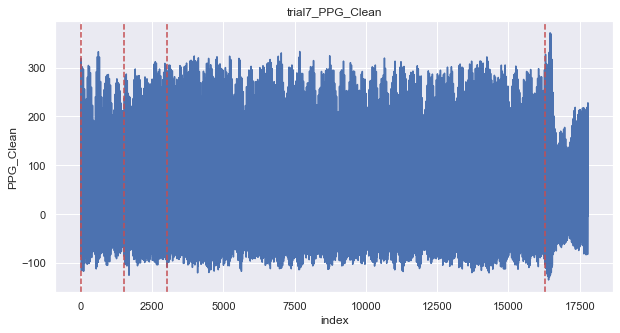

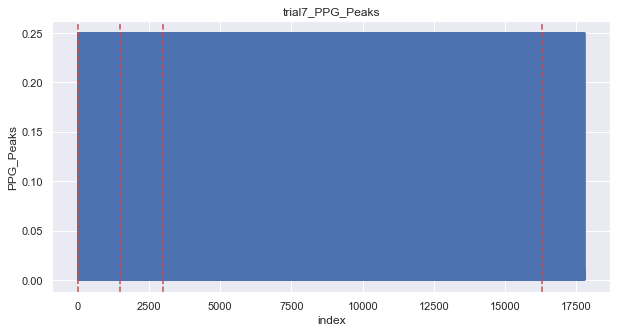

In [141]:
lst = ['EDA_Clean', 'EDA_Tonic', 'EDA_Phasic',
       'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
       'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime',
       'PPG_Clean', 'PPG_Rate', 'PPG_Peaks']
for data in tests:
    df = data.reset_index().copy()
    trial = data['Trial'][0]
    lst_s = list(df[df['Timestamp']==1].index)
    for item in lst:
        plt.figure(figsize=(10,5))
        plt.title(f'trial{trial}_{item}')
        sns.lineplot(data = df, x='index', y=item )
        for item in lst_s:
            plt.axvline(item, color='r', linestyle='--')

In [180]:
total_df[total_df['Scene']=='stimuli']

index  Timestamp     EDA_Raw   EDA_Clean   EDA_Tonic  EDA_Phasic  \
3008    3008          1  103.050293  103.063693  103.757901   -0.694207   
3009    3009          2  103.079872  103.068898  103.762656   -0.693759   
3010    3010          3  103.073143  103.074715  103.767970   -0.693255   
3011    3011          4  103.075378  103.080272  103.773149   -0.692876   
3012    3012          5  103.077698  103.085540  103.778190   -0.692650   
...      ...        ...         ...         ...         ...         ...   
82117  16283      13276  138.749863  138.735491  138.821949   -0.086469   
82118  16284      13277  138.746811  138.755529  138.778906   -0.023388   
82119  16285      13278  138.755783  138.778096  138.735181    0.042904   
82120  16286      13279  138.811127  138.801887  138.690766    0.111110   
82121  16287      13280  138.832962  138.822384  138.651345    0.171027   

       SCR_Onsets  SCR_Peaks  SCR_Height  SCR_Amplitude  SCR_RiseTime  \
3008          0.0        0.0         0.0            0.0           0.0   
3009          0.0        0.0         0.0            0.0           0.0   
3010          0.0        0.0         0.0            0.0           0.0   
3011          0.0        0.0         0.0            0.0           0.0   
3012          0.0        0.0         0.0            0.0           0.0   
...           ...        ...         ...            ...           ...   
82117         0.0        0.0         0.0            0.0           0.0   
82118         0.0        0.0         0.0            0.0           0.0   
82119         0.0        0.0         0.0            0.0           0.0   
82120         0.0        0.0         0.0            0.0           0.0   
82121         0.0        0.0         0.0            0.0           0.0   

       SCR_Recovery  SCR_RecoveryTime      PPG_Raw  PPG_Clean   PPG_Rate  \
3008            0.0               0.0  1484.033569 -27.814998  39.617484   
3009            0.0               0.0  1461.013550 -48.446912  39.659454   
3010            0.0               0.0  1446.324585 -62.592018  39.712730   
3011            0.0               0.0  1443.878174 -64.272203  39.771391   
3012            0.0               0.0  1449.649170 -57.208353  39.835000   
...             ...               ...          ...        ...        ...   
82117           0.0               0.0  1461.597168 -48.598840  42.742658   
82118           0.0               0.0  1449.593750 -62.552686  42.723499   
82119           0.0               0.0  1438.580322 -74.188956  42.705118   
82120           0.0               0.0  1428.503052 -85.089842  42.687561   
82121           0.0               0.0  1421.910767 -93.055659  42.672892   

       PPG_Peaks    Scene Trial  
3008         0.0  stimuli     1  
3009         0.0  stimuli     1  
3010         0.0  stimuli     1  
3011         0.0  stimuli     1  
3012         0.0  stimuli     1  
...          ...      ...   ...  
82117        0.0  stimuli     7  
82118        0.0  stimuli     7  
82119        0.0  stimuli     7  
82120        0.0  stimuli     7  
82121        0.0  stimuli     7  

[56560 rows x 19 columns]

In [5]:
lst = ['EDA_Clean', 'EDA_Tonic', 'EDA_Phasic','SCR_Amplitude','PPG_Rate']

for data in tests:
    plt.figure(figsize=(20,5))
    plt.title(f'trial{trial}_{item}')
    
    df = data.reset_index().copy()
    trial = data['Trial'][0]
    lst_s = list(df[df['Timestamp']==1].index)

    for item in lst:
        sns.lineplot(data = df, x='index', y=item , label=item)

        for item in lst_s:
            plt.axvline(item, color='r', linestyle='--')

    plt.legend(loc='lower right', bbox_to_anchor=(1.12,0))
    plt.plot()

NameError: name 'item' is not defined

<Figure size 1440x360 with 0 Axes>

In [76]:
ppg = nk.ppg_simulate(duration=20, sampling_rate=1000)
ppg_signals, info = nk.ppg_process(ppg, sampling_rate=1000)
data = nk.epochs_create(ppg_signals, events=[5000, 10000, 15000],
                         epochs_start=-0.1, epochs_end=1.9)

In [83]:
v

index  Timestamp    EDA_Raw  EDA_Clean  EDA_Tonic  EDA_Phasic  \
0.000000      0          1  86.483398  86.500662  87.259828   -0.759166   
0.020057      1          2  86.508224  86.509311  87.271946   -0.762635   
0.040115      2          3  86.513962  86.520928  87.284155   -0.763227   
0.060172      3          4  86.534775  86.537060  87.296453   -0.759393   
0.080229      4          5  86.567215  86.558979  87.308842   -0.749863   
...         ...        ...        ...        ...        ...         ...   
6.919771    345        346  92.981125  92.968669  90.380015    2.588654   
6.939828    346        347  92.979141  92.984019  90.345322    2.638697   
6.959885    347        348  92.995483  92.997966  90.310019    2.687946   
6.979943    348        349  93.000702  93.010837  90.274103    2.736734   
7.000000    349        350  93.033478  93.022506  90.237572    2.784934   

          SCR_Onsets  SCR_Peaks  SCR_Height  SCR_Amplitude  ...  SCR_Recovery  \
0.000000         0.0        0.0         0.0            0.0  ...           0.0   
0.020057         0.0        0.0         0.0            0.0  ...           0.0   
0.040115         0.0        0.0         0.0            0.0  ...           0.0   
0.060172         0.0        0.0         0.0            0.0  ...           0.0   
0.080229         0.0        0.0         0.0            0.0  ...           0.0   
...              ...        ...         ...            ...  ...           ...   
6.919771         0.0        0.0         0.0            0.0  ...           0.0   
6.939828         0.0        0.0         0.0            0.0  ...           0.0   
6.959885         0.0        0.0         0.0            0.0  ...           0.0   
6.979943         0.0        0.0         0.0            0.0  ...           0.0   
7.000000         0.0        0.0         0.0            0.0  ...           0.0   

          SCR_RecoveryTime      PPG_Raw  PPG_Clean   PPG_Rate  PPG_Peaks  \
0.000000               0.0  1435.276855 -36.725412  41.220570        0.0   
0.020057               0.0  1438.291626 -38.442091  41.220570        0.0   
0.040115               0.0  1442.802368 -39.592246  41.220570        0.0   
0.060172               0.0  1448.883545 -39.413366  41.220570        0.0   
0.080229               0.0  1455.071167 -38.573067  41.220570        0.0   
...                    ...          ...        ...        ...        ...   
6.919771               0.0  1582.331299  61.876435  39.067649        0.0   
6.939828               0.0  1530.490234  10.689366  39.031897        0.0   
6.959885               0.0  1491.591064 -25.906680  38.996234        0.0   
6.979943               0.0  1464.985840 -50.816880  38.960681        0.0   
7.000000               0.0  1448.808472 -64.337757  38.925254        0.0   

           Scene Trial Index  Label  
0.000000  breath     1     0  base1  
0.020057  breath     1     1  base1  
0.040115  breath     1     2  base1  
0.060172  breath     1     3  base1  
0.080229  breath     1     4  base1  
...          ...   ...   ...    ...  
6.919771  breath     1   345  base1  
6.939828  breath     1   346  base1  
6.959885  breath     1   347  base1  
6.979943  breath     1   348  base1  
7.000000  breath     1   349  base1  

[350 rows x 21 columns]

c:\Users\user\anaconda3\envs\torch\lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Users\user\anaconda3\envs\torch\lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Users\user\anaconda3\envs\torch\lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of wi

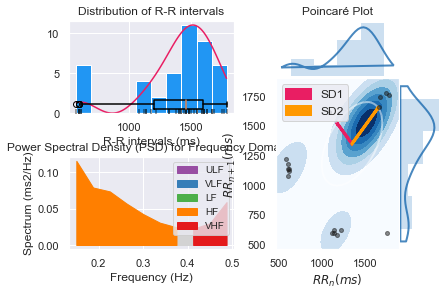

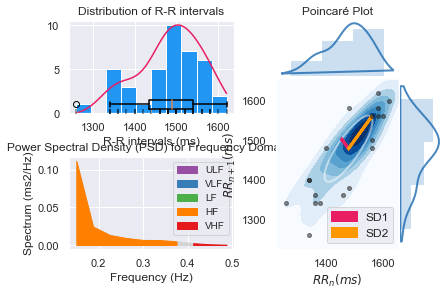

In [130]:
for trial in list(total_df['Trial'].unique()):
    df = total_df.loc[(total_df['Scene']=='breath')&(total_df['Trial']==trial),'PPG_Clean']
    peaks = nk.ppg_peaks(df, sampling_rate=50)
    # nk.hrv(peaks[1]['PPG_Peaks'], sampling_rate=50,show=True)
    rrint = nk.hrv(peaks[1]['PPG_Peaks'], sampling_rate=50,show=True)
    

In [132]:
peaks[1]['PPG_Peaks']

array([  27,  106,  184,  258,  331,  399,  467,  534,  604,  675,  748,
        823,  897,  966, 1033, 1096, 1163, 1233, 1307, 1386, 1465, 1546,
       1626, 1704, 1782, 1857, 1930, 2005, 2081, 2158, 2235, 2311, 2385,
       2458, 2530, 2604, 2679, 2755, 2832, 2909, 2984])

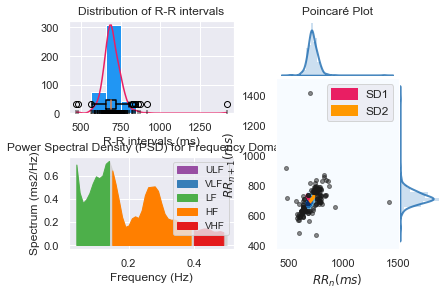

In [11]:
import neurokit2 as nk

# Download data
data = nk.data("bio_resting_5min_100hz")

# Find peaks
peaks, info = nk.ecg_peaks(data["ECG"], sampling_rate=100)

# Compute HRV indices
hrv = nk.hrv(peaks, sampling_rate=100, show=True)

In [138]:
data

ECG       PPG       RSP
0      0.003766 -0.102539  0.494652
1     -0.017466 -0.103760  0.502483
2     -0.015679 -0.107422  0.511102
3     -0.001598 -0.110855  0.518791
4      0.002483 -0.112610  0.528669
...         ...       ...       ...
29995 -0.045986 -0.135498  0.981111
29996 -0.107841 -0.155334  0.978866
29997 -0.058274 -0.173721  0.976366
29998 -0.056472 -0.192108  0.972202
29999 -0.044856 -0.209579  0.969100

[30000 rows x 3 columns]

In [21]:
total_df.loc[(total_df['Scene']=='breath')&(total_df['Trial']==trial)]

index  Timestamp    EDA_Raw  EDA_Clean  EDA_Tonic  EDA_Phasic  \
65834      0          1  66.988586  67.313185  68.142886   -0.829703   
65835      1          2  67.111198  67.382367  68.144051   -0.761685   
65836      2          3  67.224091  67.453693  68.145216   -0.691524   
65837      3          4  67.350357  67.527087  68.146382   -0.619295   
65838      4          5  67.455864  67.602468  68.147548   -0.545080   
...      ...        ...        ...        ...        ...         ...   
67331   1497       1498  71.521500  71.579093  71.783031   -0.203938   
67332   1498       1499  71.542946  71.597615  71.787866   -0.190251   
67333   1499       1500  71.554916  71.615216  71.792706   -0.177489   
67334   1500       1501  71.573097  71.631829  71.797548   -0.165719   
67335   1501       1502  71.590736  71.645523  71.801789   -0.156266   

       SCR_Onsets  SCR_Peaks  SCR_Height  SCR_Amplitude  SCR_RiseTime  \
65834         0.0        0.0         0.0            0.0           0.0   
65835         0.0        0.0         0.0            0.0           0.0   
65836         0.0        0.0         0.0            0.0           0.0   
65837         0.0        0.0         0.0            0.0           0.0   
65838         0.0        0.0         0.0            0.0           0.0   
...           ...        ...         ...            ...           ...   
67331         0.0        0.0         0.0            0.0           0.0   
67332         0.0        0.0         0.0            0.0           0.0   
67333         0.0        0.0         0.0            0.0           0.0   
67334         0.0        0.0         0.0            0.0           0.0   
67335         0.0        0.0         0.0            0.0           0.0   

       SCR_Recovery  SCR_RecoveryTime      PPG_Raw  PPG_Clean   PPG_Rate  \
65834           0.0               0.0  1423.654175 -12.482123  27.289783   
65835           0.0               0.0  1427.265991  -0.109244  27.289783   
65836           0.0               0.0  1430.193481  13.484343  27.289783   
65837           0.0               0.0  1432.257935  28.083689  27.289783   
65838           0.0               0.0  1432.738403  43.411938  27.289783   
...             ...               ...          ...        ...        ...   
67331           0.0               0.0  1499.942505  46.706590  15.748823   
67332           0.0               0.0  1473.711914  38.253004  15.733799   
67333           0.0               0.0  1457.319580  28.908116  15.718790   
67334           0.0               0.0  1451.487305  19.000368  15.703798   
67335           0.0               0.0  1455.066528  10.121556  15.690692   

       PPG_Peaks   Scene Trial  
65834        0.0  breath     7  
65835        0.0  breath     7  
65836        0.0  breath     7  
65837        0.0  breath     7  
65838        0.0  breath     7  
...          ...     ...   ...  
67331        0.0  breath     7  
67332        0.0  breath     7  
67333        0.0  breath     7  
67334        0.0  breath     7  
67335        0.0  breath     7  

[1502 rows x 19 columns]

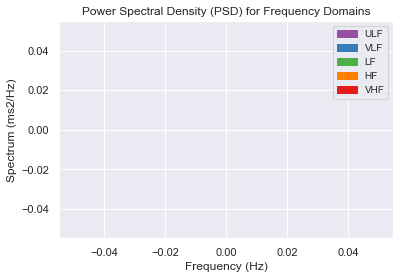

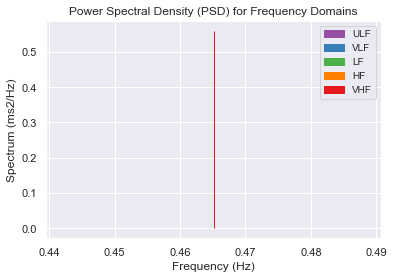

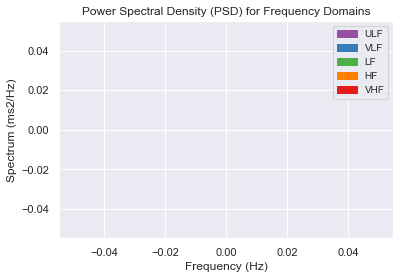

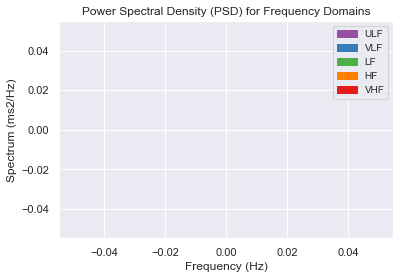

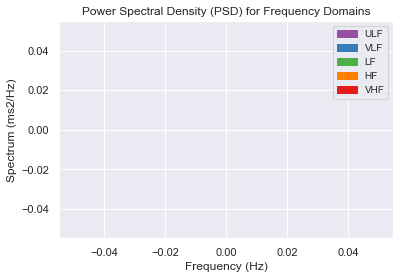

In [130]:
for trial in list(total_df['Trial'].unique()):
    df = total_df.loc[(total_df['Scene']=='breath')&(total_df['Trial']==trial)&(total_df['Timestamp']<350),'PPG_Peaks']
    peaks = nk.ppg_peaks(df, sampling_rate=50)
    nk.hrv_frequency(peaks[1]['PPG_Peaks'], sampling_rate=50,show=True)

In [110]:
peaks[1]['PPG_Peaks']

array([ 48,  83, 120, 157, 194, 230, 266, 303, 341])

In [106]:
total_df.loc[(total_df['Scene']=='breath')&(total_df['Trial']=='1')&(total_df['Timestamp']<350)]

index  Timestamp    EDA_Raw  EDA_Clean  EDA_Tonic  EDA_Phasic  \
0        0          1  86.483398  86.500662  87.259828   -0.759166   
1        1          2  86.508224  86.509311  87.271946   -0.762635   
2        2          3  86.513962  86.520928  87.284155   -0.763227   
3        3          4  86.534775  86.537060  87.296453   -0.759393   
4        4          5  86.567215  86.558979  87.308842   -0.749863   
..     ...        ...        ...        ...        ...         ...   
344    344        345  92.952682  92.951261  90.414099    2.537162   
345    345        346  92.981125  92.968669  90.380015    2.588654   
346    346        347  92.979141  92.984019  90.345322    2.638697   
347    347        348  92.995483  92.997966  90.310019    2.687946   
348    348        349  93.000702  93.010837  90.274103    2.736734   

     SCR_Onsets  SCR_Peaks  SCR_Height  SCR_Amplitude  SCR_RiseTime  \
0           0.0        0.0         0.0            0.0           0.0   
1           0.0        0.0         0.0            0.0           0.0   
2           0.0        0.0         0.0            0.0           0.0   
3           0.0        0.0         0.0            0.0           0.0   
4           0.0        0.0         0.0            0.0           0.0   
..          ...        ...         ...            ...           ...   
344         0.0        0.0         0.0            0.0           0.0   
345         0.0        0.0         0.0            0.0           0.0   
346         0.0        0.0         0.0            0.0           0.0   
347         0.0        0.0         0.0            0.0           0.0   
348         0.0        0.0         0.0            0.0           0.0   

     SCR_Recovery  SCR_RecoveryTime      PPG_Raw   PPG_Clean   PPG_Rate  \
0             0.0               0.0  1435.276855  -36.725412  41.220570   
1             0.0               0.0  1438.291626  -38.442091  41.220570   
2             0.0               0.0  1442.802368  -39.592246  41.220570   
3             0.0               0.0  1448.883545  -39.413366  41.220570   
4             0.0               0.0  1455.071167  -38.573067  41.220570   
..            ...               ...          ...         ...        ...   
344           0.0               0.0  1647.607178  124.909729  39.103474   
345           0.0               0.0  1582.331299   61.876435  39.067649   
346           0.0               0.0  1530.490234   10.689366  39.031897   
347           0.0               0.0  1491.591064  -25.906680  38.996234   
348           0.0               0.0  1464.985840  -50.816880  38.960681   

     PPG_Peaks   Scene Trial  
0          0.0  breath     1  
1          0.0  breath     1  
2          0.0  breath     1  
3          0.0  breath     1  
4          0.0  breath     1  
..         ...     ...   ...  
344        0.0  breath     1  
345        0.0  breath     1  
346        0.0  breath     1  
347        0.0  breath     1  
348        0.0  breath     1  

[349 rows x 19 columns]

In [101]:
total_df.loc[total_df['Scene']=='breath']

index  Timestamp    EDA_Raw  EDA_Clean  EDA_Tonic  EDA_Phasic  \
0          0          1  86.483398  86.500662  87.259828   -0.759166   
1          1          2  86.508224  86.509311  87.271946   -0.762635   
2          2          3  86.513962  86.520928  87.284155   -0.763227   
3          3          4  86.534775  86.537060  87.296453   -0.759393   
4          4          5  86.567215  86.558979  87.308842   -0.749863   
...      ...        ...        ...        ...        ...         ...   
67331   1497       1498  71.521500  71.524311  69.958041    1.566270   
67332   1498       1499  71.542946  71.539869  69.965947    1.573921   
67333   1499       1500  71.554916  71.556039  69.973658    1.582381   
67334   1500       1501  71.573097  71.573862  69.981173    1.592689   
67335   1501       1502  71.590736  71.591328  69.987593    1.603736   

       SCR_Onsets  SCR_Peaks  SCR_Height  SCR_Amplitude  SCR_RiseTime  \
0             0.0        0.0         0.0            0.0           0.0   
1             0.0        0.0         0.0            0.0           0.0   
2             0.0        0.0         0.0            0.0           0.0   
3             0.0        0.0         0.0            0.0           0.0   
4             0.0        0.0         0.0            0.0           0.0   
...           ...        ...         ...            ...           ...   
67331         0.0        0.0         0.0            0.0           0.0   
67332         0.0        0.0         0.0            0.0           0.0   
67333         0.0        0.0         0.0            0.0           0.0   
67334         0.0        0.0         0.0            0.0           0.0   
67335         0.0        0.0         0.0            0.0           0.0   

       SCR_Recovery  SCR_RecoveryTime      PPG_Raw  PPG_Clean   PPG_Rate  \
0               0.0               0.0  1435.276855 -36.725412  41.220570   
1               0.0               0.0  1438.291626 -38.442091  41.220570   
2               0.0               0.0  1442.802368 -39.592246  41.220570   
3               0.0               0.0  1448.883545 -39.413366  41.220570   
4               0.0               0.0  1455.071167 -38.573067  41.220570   
...             ...               ...          ...        ...        ...   
67331           0.0               0.0  1499.942505 -20.083902  40.288642   
67332           0.0               0.0  1473.711914 -45.265686  40.351438   
67333           0.0               0.0  1457.319580 -61.093566  40.417207   
67334           0.0               0.0  1451.487305 -66.533942  40.485748   
67335           0.0               0.0  1455.066528 -62.839915  40.547793   

       PPG_Peaks   Scene Trial  
0            0.0  breath     1  
1            0.0  breath     1  
2            0.0  breath     1  
3            0.0  breath     1  
4            0.0  breath     1  
...          ...     ...   ...  
67331        0.0  breath     7  
67332        0.0  breath     7  
67333        0.0  breath     7  
67334        0.0  breath     7  
67335        0.0  breath     7  

[8992 rows x 19 columns]

In [153]:
df = total_df[total_df['Scene']=='breath']
epochs = {}
for trial in list(df['Trial'].unique()):
    _df = df[df['Trial']==trial]
    epoch = nk.epochs_create(_df, sampling_rate=1000, events=[400,700,1000,1300,2000,2300,2600],event_labels=[f'base/{trial}',f'inhale_b/{trial}',f'inhale_a/{trial}',f'hold/{trial}',f'exhale_b/{trial}',f'exhale_a/{trial}',f'end/{trial}', ])
    epochs.update(epoch)

ppg_breath = nk.ppg_analyze(epochs, method='event-related')

In [108]:
epochs['base1']

index  Timestamp    EDA_Raw  EDA_Clean  EDA_Tonic  EDA_Phasic  \
0.000000      0          1  86.278717  86.268921  87.973386   -1.704465   
0.001001      1          2  86.467560  86.500626  87.259825   -0.759199   
0.002003      2          3  86.499229  86.504660  87.265873   -0.761213   
0.003004      3          4  86.517227  86.509217  87.271943   -0.762726   
0.004006      4          5  86.499229  86.514523  87.278036   -0.763513   
...         ...        ...        ...        ...        ...         ...   
0.695994    695        696  93.012115  92.997998  90.310038    2.687959   
0.696996    696        697  92.956787  93.004564  90.292157    2.712407   
0.697997    697        698  93.036285  93.010873  90.274122    2.736750   
0.698999    698        699  93.031372  93.016892  90.255934    2.760958   
0.700000    699        700  93.015099  93.022561  90.237591    2.784969   

          SCR_Onsets  SCR_Peaks  SCR_Height  SCR_Amplitude  ...  SCR_Recovery  \
0.000000         0.0        0.0         0.0            0.0  ...           0.0   
0.001001         0.0        0.0         0.0            0.0  ...           0.0   
0.002003         0.0        0.0         0.0            0.0  ...           0.0   
0.003004         0.0        0.0         0.0            0.0  ...           0.0   
0.004006         0.0        0.0         0.0            0.0  ...           0.0   
...              ...        ...         ...            ...  ...           ...   
0.695994         0.0        0.0         0.0            0.0  ...           0.0   
0.696996         0.0        0.0         0.0            0.0  ...           0.0   
0.697997         0.0        0.0         0.0            0.0  ...           0.0   
0.698999         0.0        0.0         0.0            0.0  ...           0.0   
0.700000         0.0        0.0         0.0            0.0  ...           0.0   

          SCR_RecoveryTime      PPG_Raw   PPG_Clean   PPG_Rate  PPG_Peaks  \
0.000000               0.0  1601.968262  104.790281  39.848481        0.0   
0.001001               0.0  1435.991211  -36.718870  41.220570        0.0   
0.002003               0.0  1435.978638  -37.599460  41.220570        0.0   
0.003004               0.0  1438.239258  -38.459668  41.220570        0.0   
0.004006               0.0  1441.725952  -39.180322  41.220570        0.0   
...                    ...          ...         ...        ...        ...   
0.695994               0.0  1490.935303  -26.256506  38.996231        0.0   
0.696996               0.0  1478.143799  -40.012918  38.978439        0.0   
0.697997               0.0  1464.136353  -51.169664  38.960677        0.0   
0.698999               0.0  1453.894775  -59.499661  38.942946        0.0   
0.700000               0.0  1448.615479  -64.716139  38.925249        0.0   

           Scene Trial Index  Label  
0.000000  breath     1     0  base1  
0.001001  breath     1     1  base1  
0.002003  breath     1     2  base1  
0.003004  breath     1     3  base1  
0.004006  breath     1     4  base1  
...          ...   ...   ...    ...  
0.695994  breath     1   695  base1  
0.696996  breath     1   696  base1  
0.697997  breath     1   697  base1  
0.698999  breath     1   698  base1  
0.700000  breath     1   699  base1  

[700 rows x 21 columns]

In [161]:
epoch.columns

Index(['Event_Onset', 'PPG_Rate_Baseline', 'PPG_Rate_Max', 'PPG_Rate_Min',
       'PPG_Rate_Mean', 'PPG_Rate_SD', 'PPG_Rate_Max_Time',
       'PPG_Rate_Min_Time', 'PPG_Rate_Trend_Linear',
       'PPG_Rate_Trend_Quadratic', 'PPG_Rate_Trend_R2', 'Scene', 'Trial'],
      dtype='object')

<Axes: title={'center': 'epochs'}, xlabel='Scene', ylabel='PPG_Rate_Trend_Linear'>

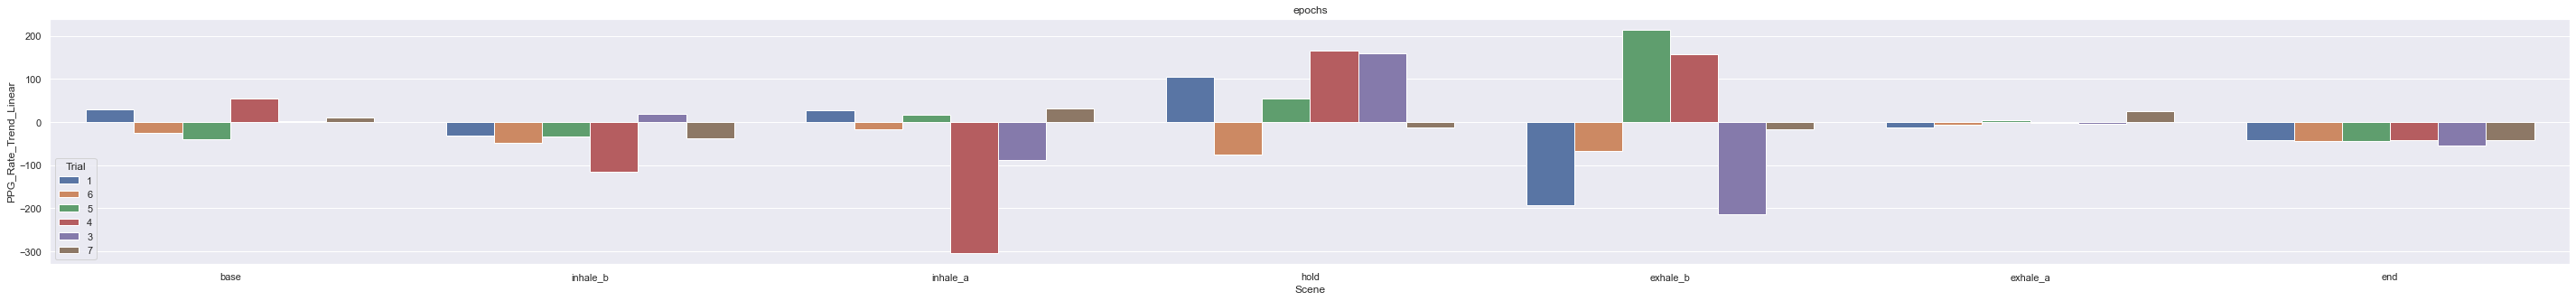

In [167]:
epoch = nk.ppg_analyze(epochs, sampling_rate=1000)

epoch[['Scene', 'Trial']] = epoch['Label'].str.split('/', n=1, expand=True)
epoch = epoch.drop(columns=["Label"]).reset_index(drop=True)
plt.figure(figsize=(50,5))
plt.title("epochs")
sns.barplot(data=epoch, x='Scene', y='PPG_Rate_Trend_Linear', hue='Trial')

In [150]:
hrvs = {}
for k, v in epochs.items():
    df = v[["PPG_Raw","PPG_Clean","PPG_Rate","PPG_Peaks", "Timestamp"]]
    df = df.loc[df["PPG_Peaks"]!=0,"Timestamp"].to_numpy()
    hrv = nk.hrv(df, sampling_rate=50,show=True)

    
    hrvs[k] = hrv

ValueError: It seems that you are trying to pass a single epoch to an eventrelated function.If this is what you want, please wrap it in a dict: `{"0": epoch}` 

array([463, 534, 607, 684], dtype=int64)

C:\Users\user\AppData\Local\Temp\ipykernel_19752\3785849908.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(50,5))


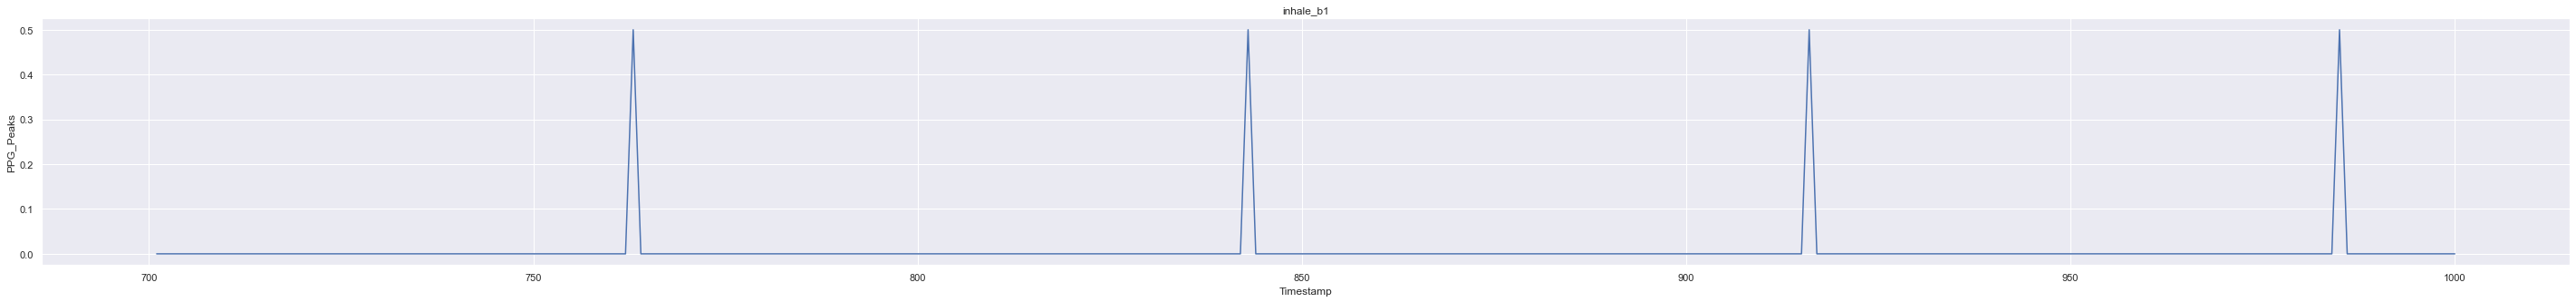

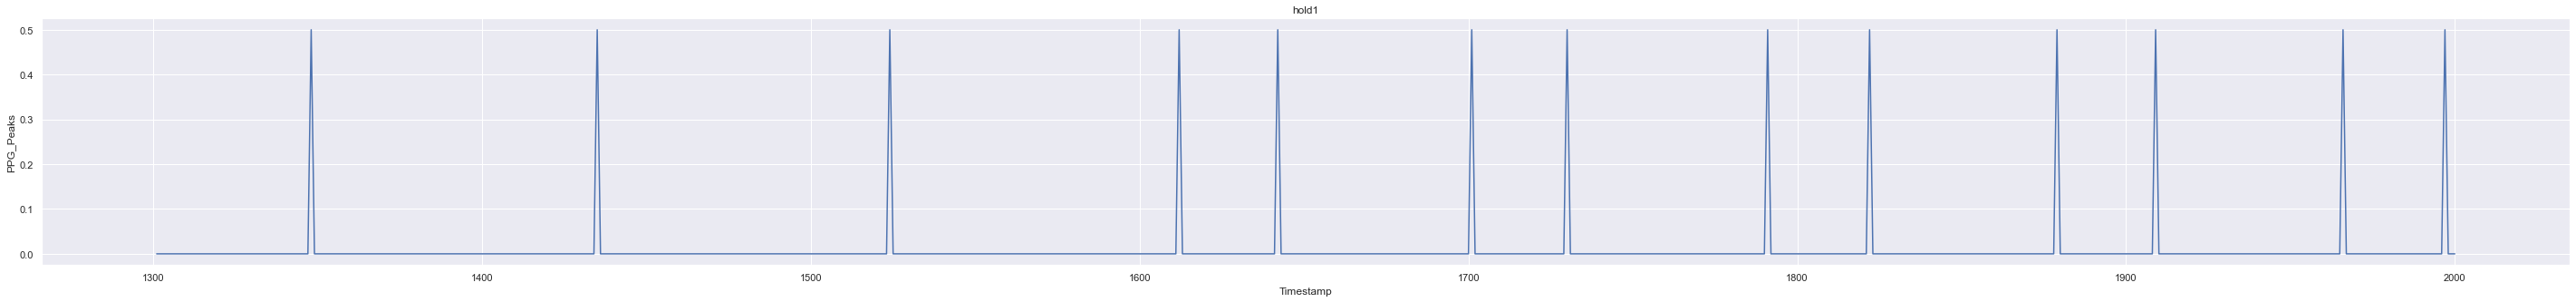

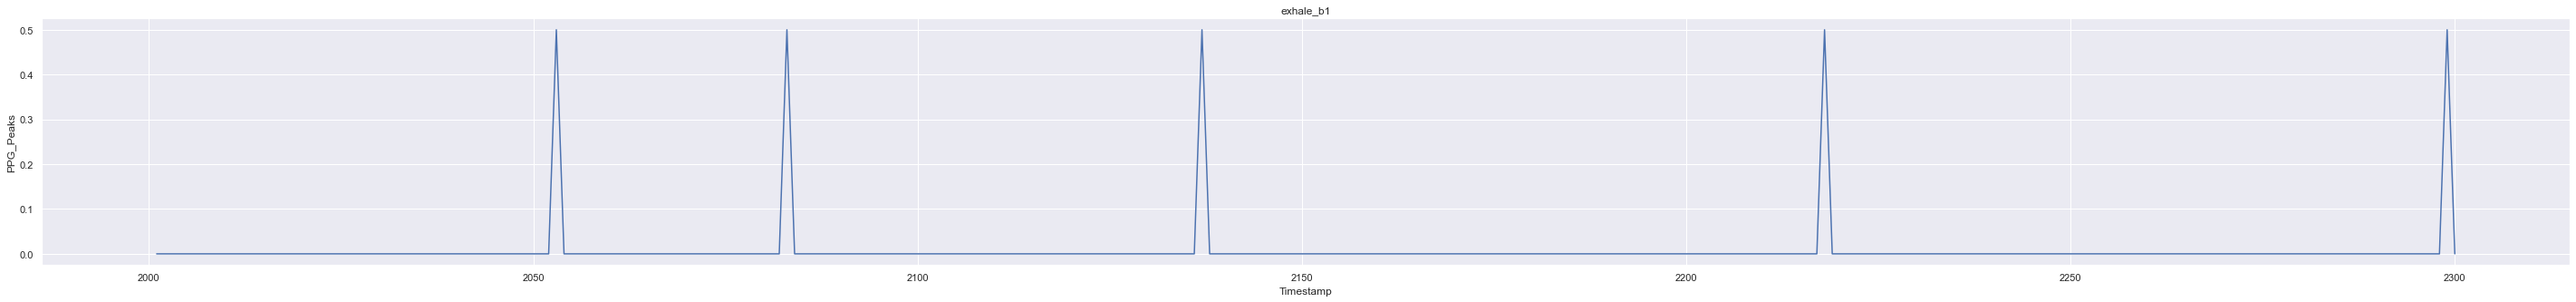

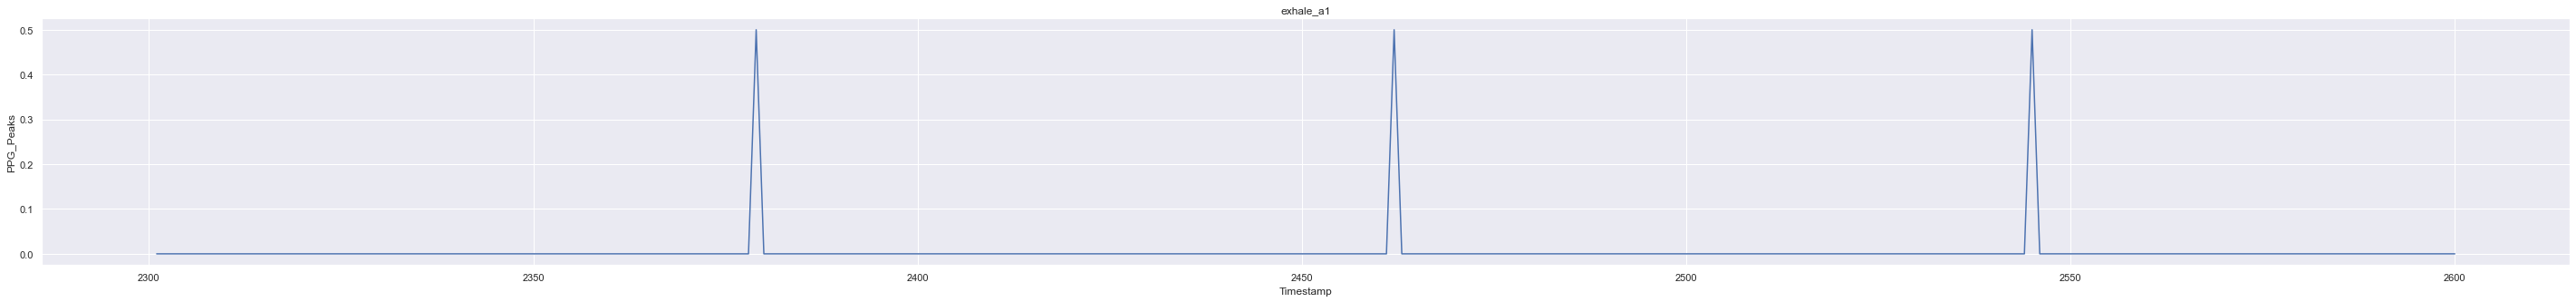

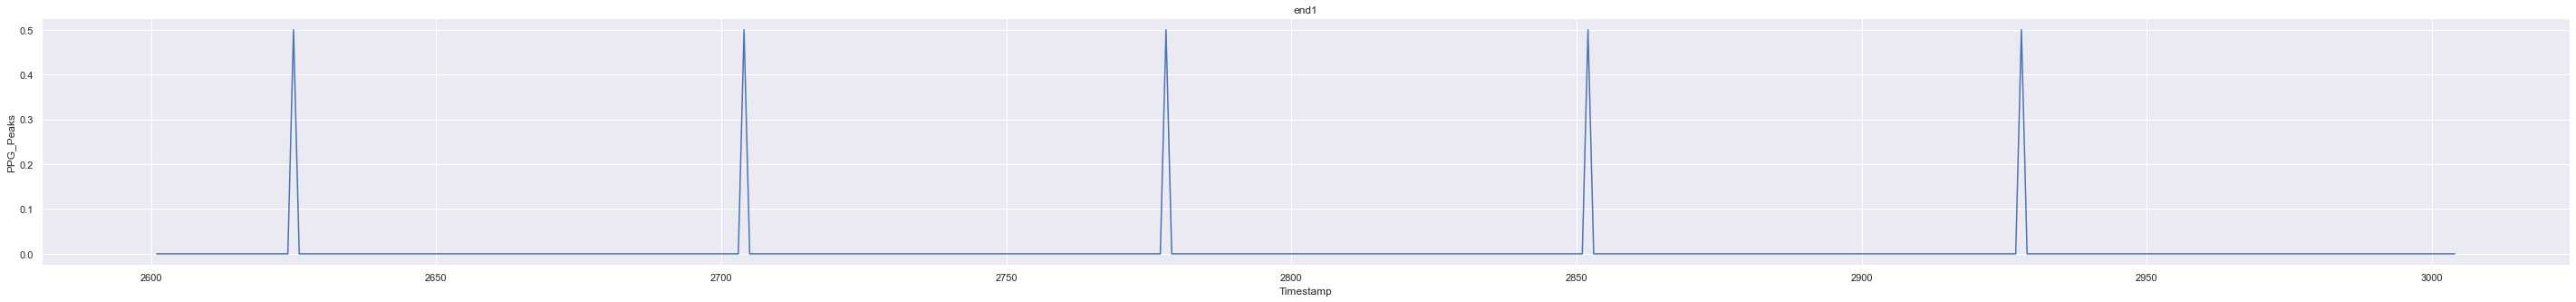

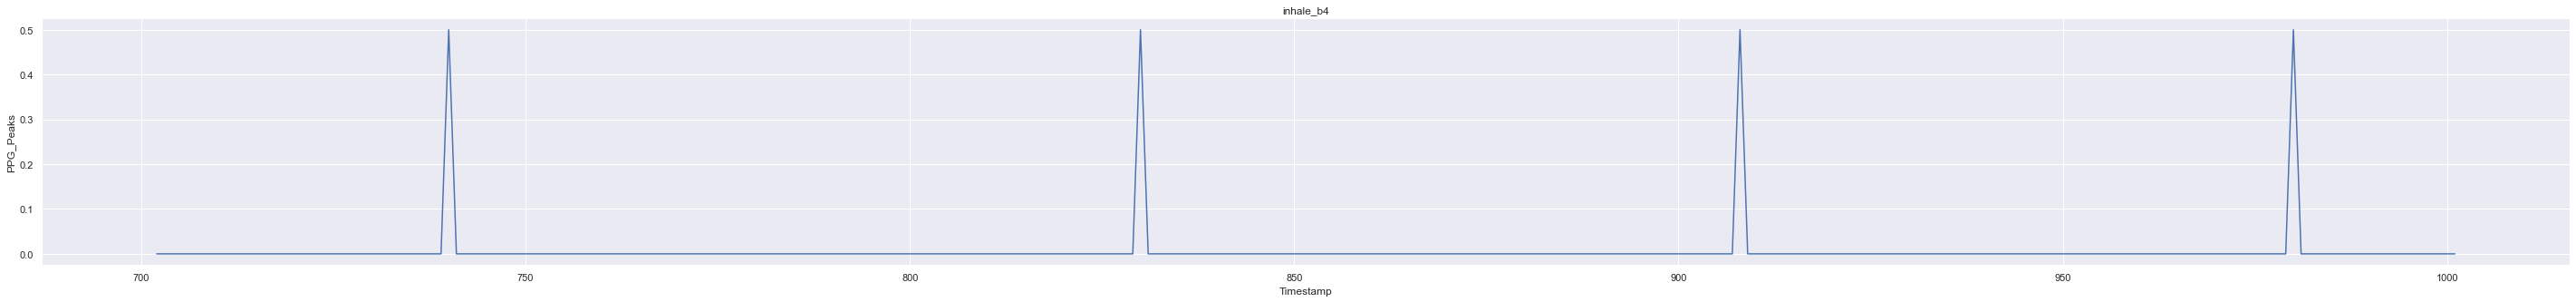

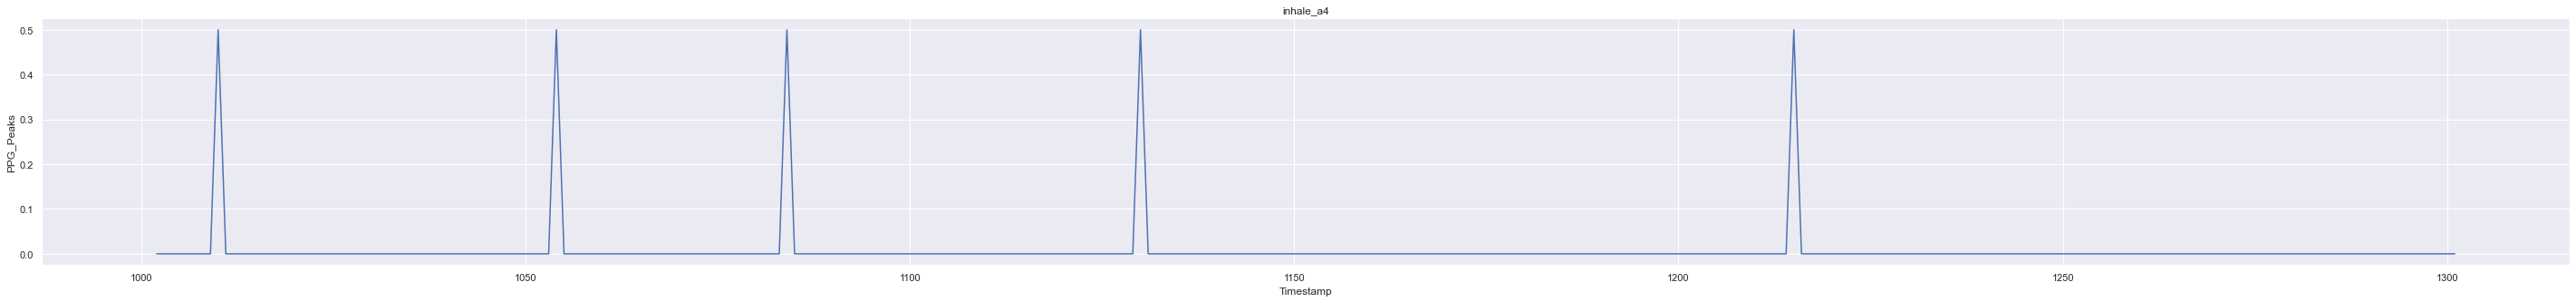

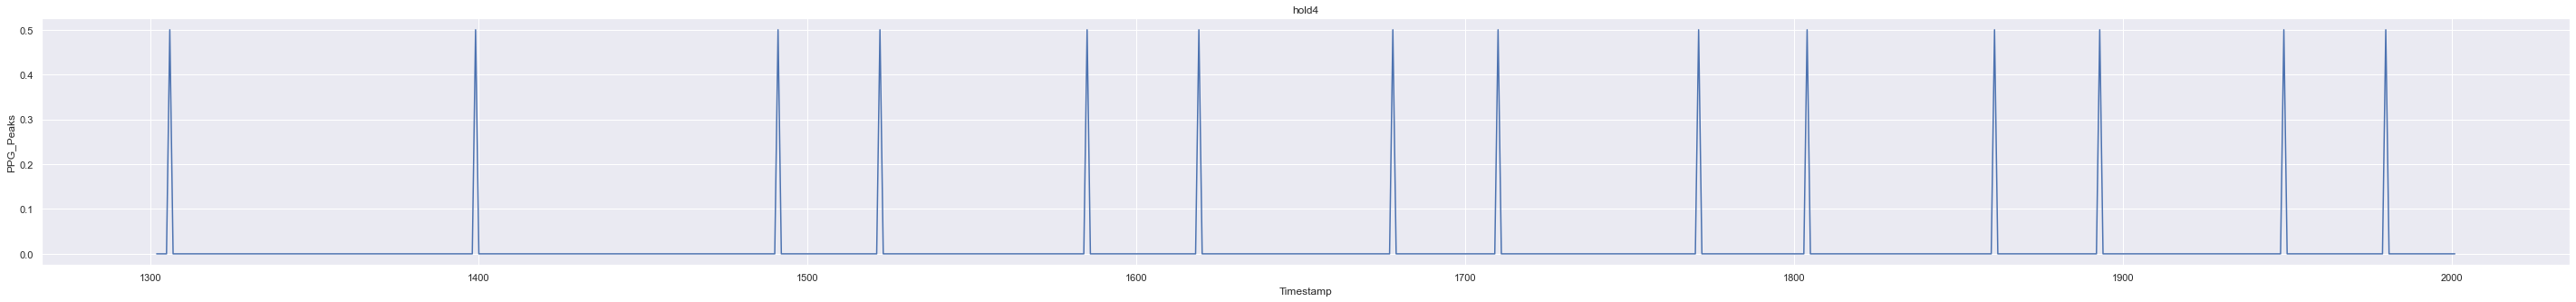

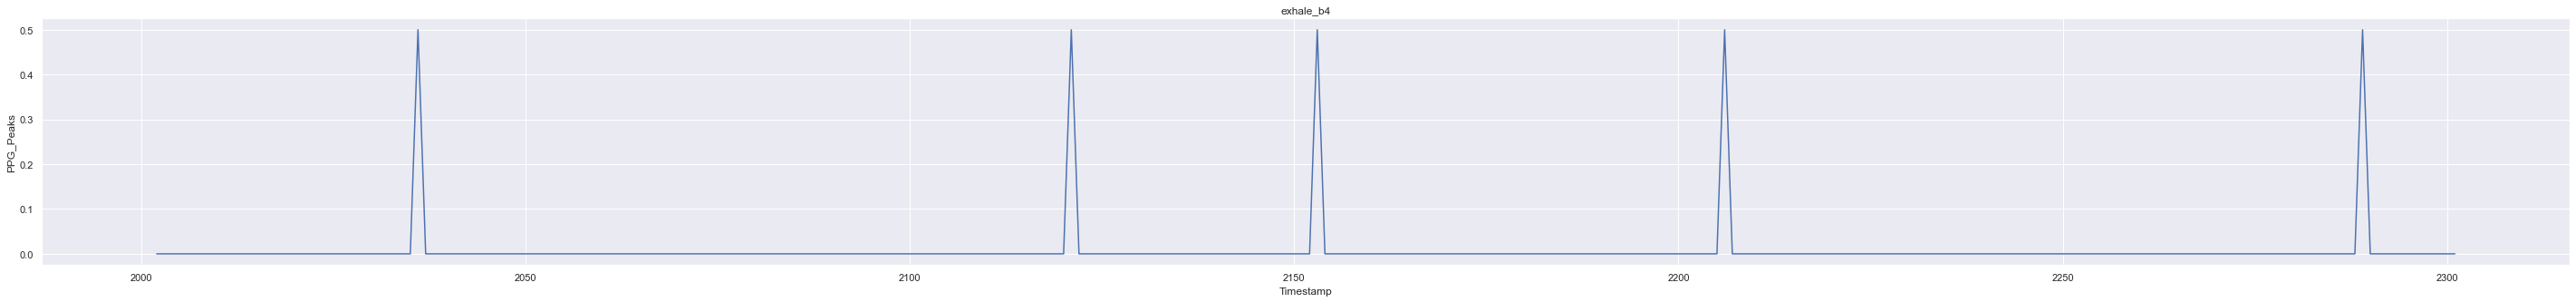

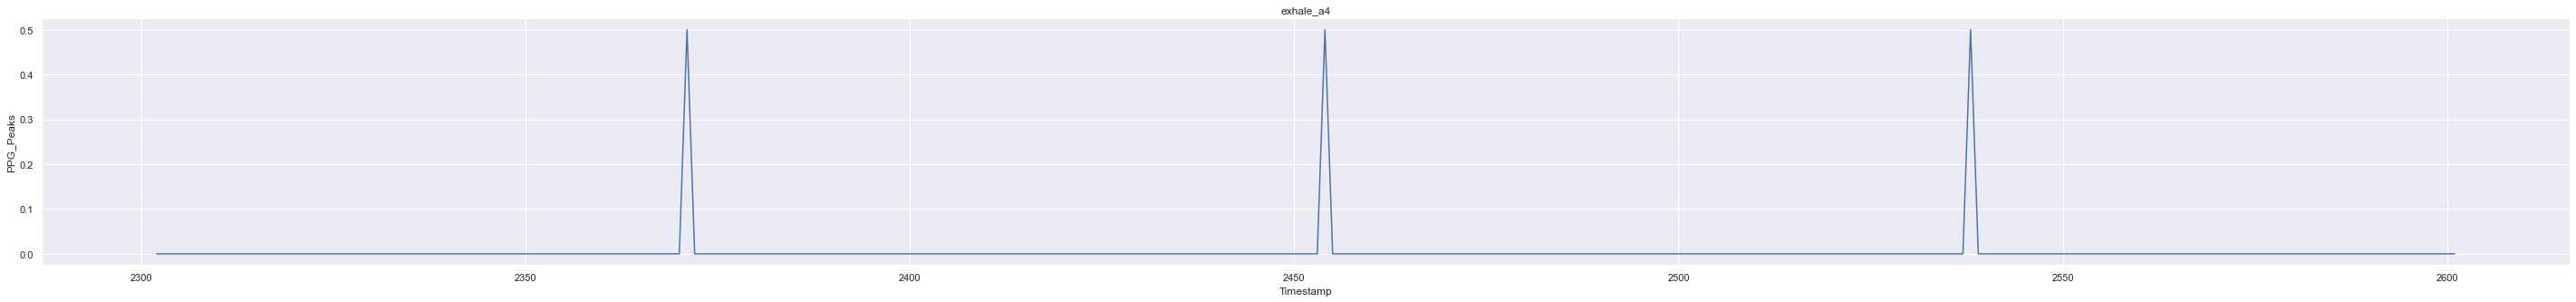

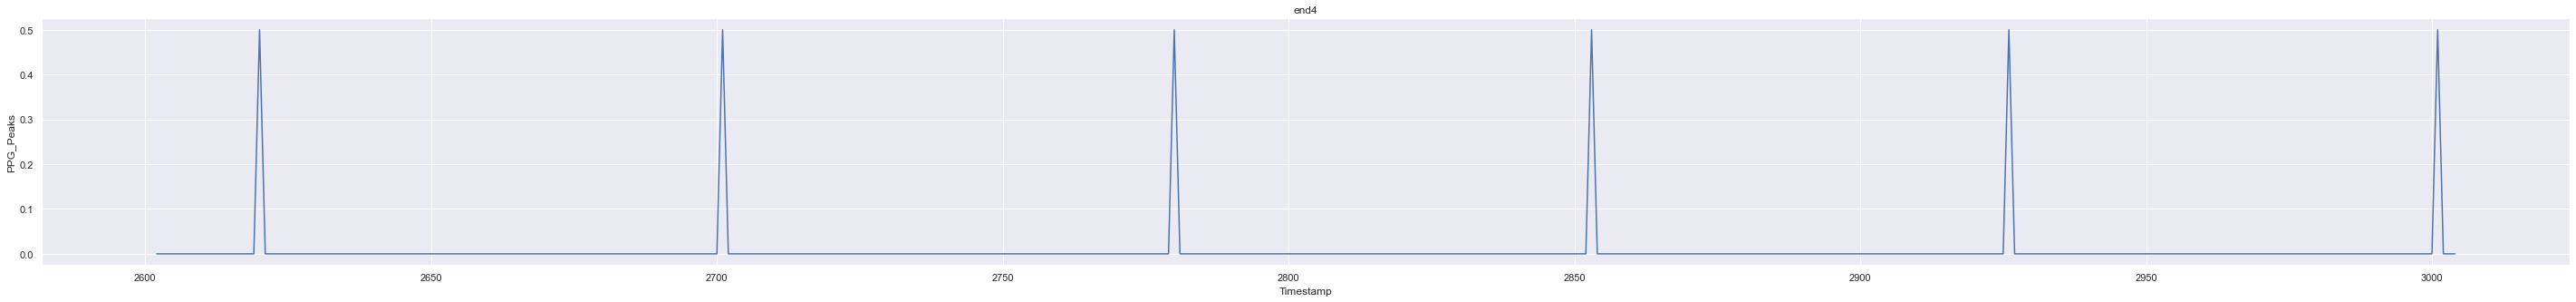

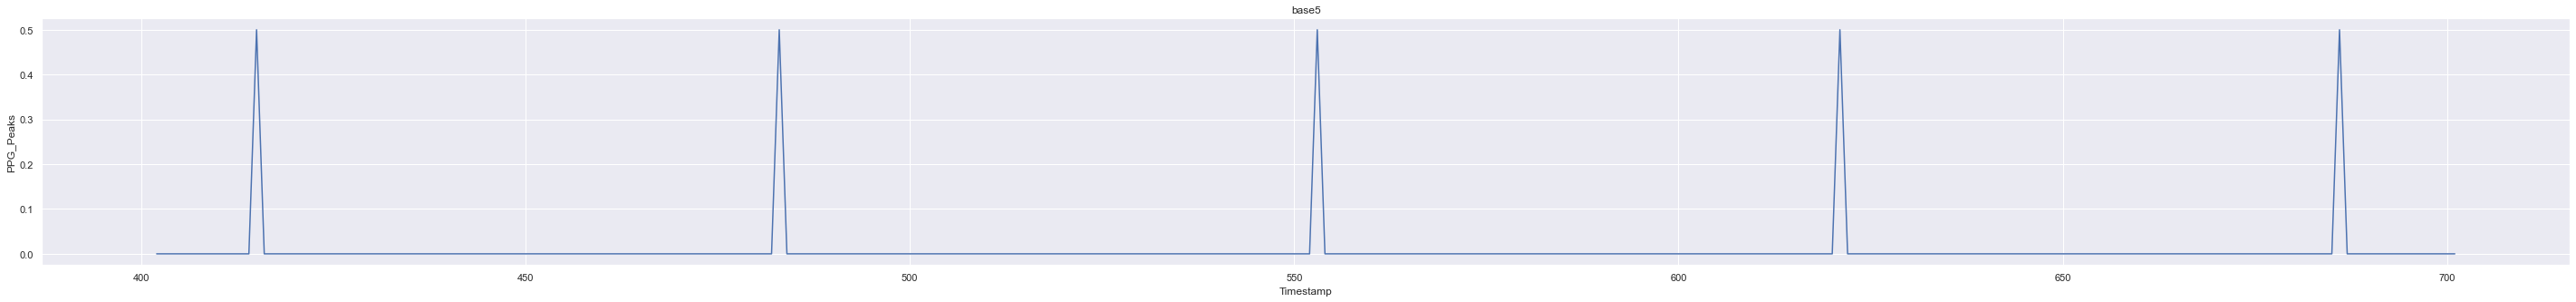

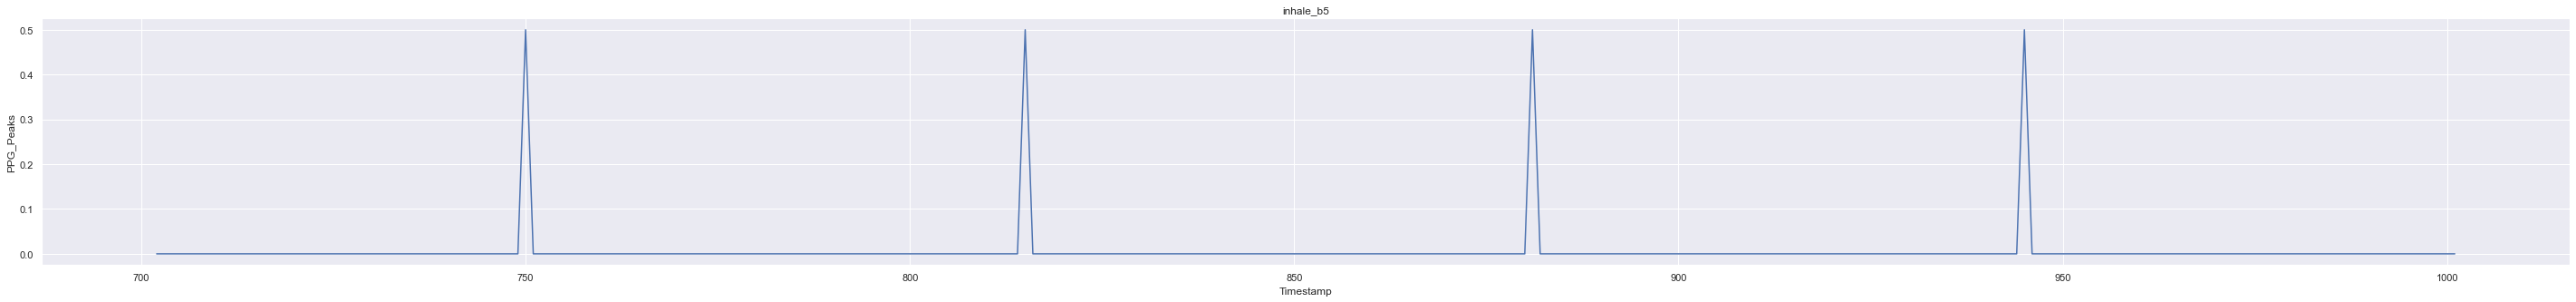

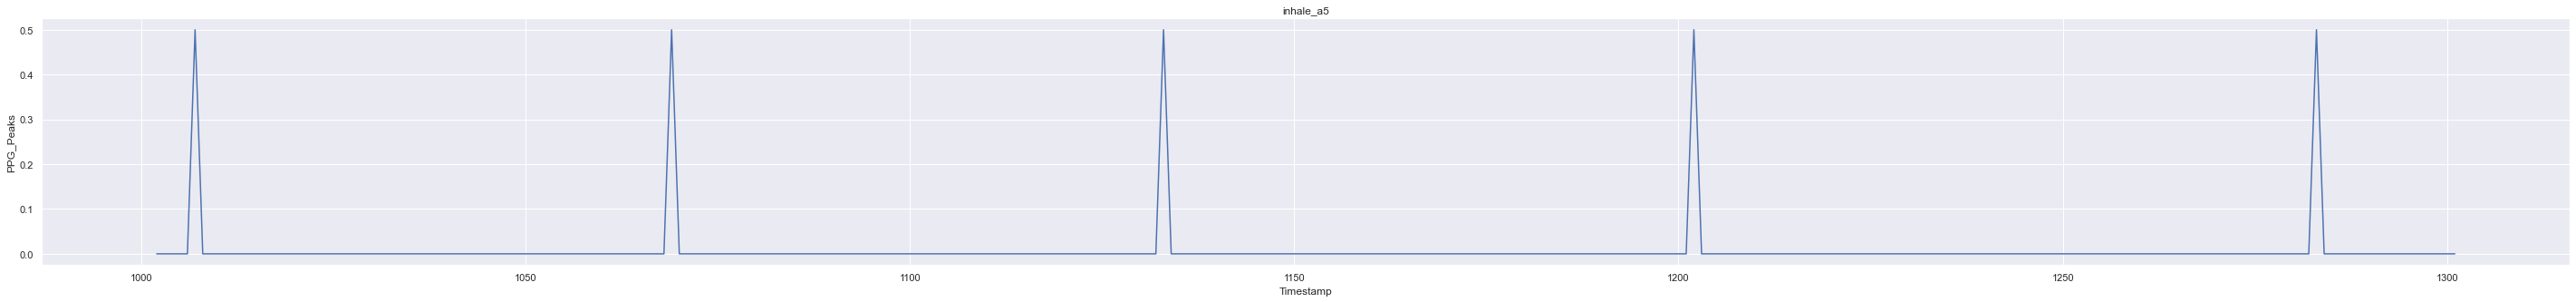

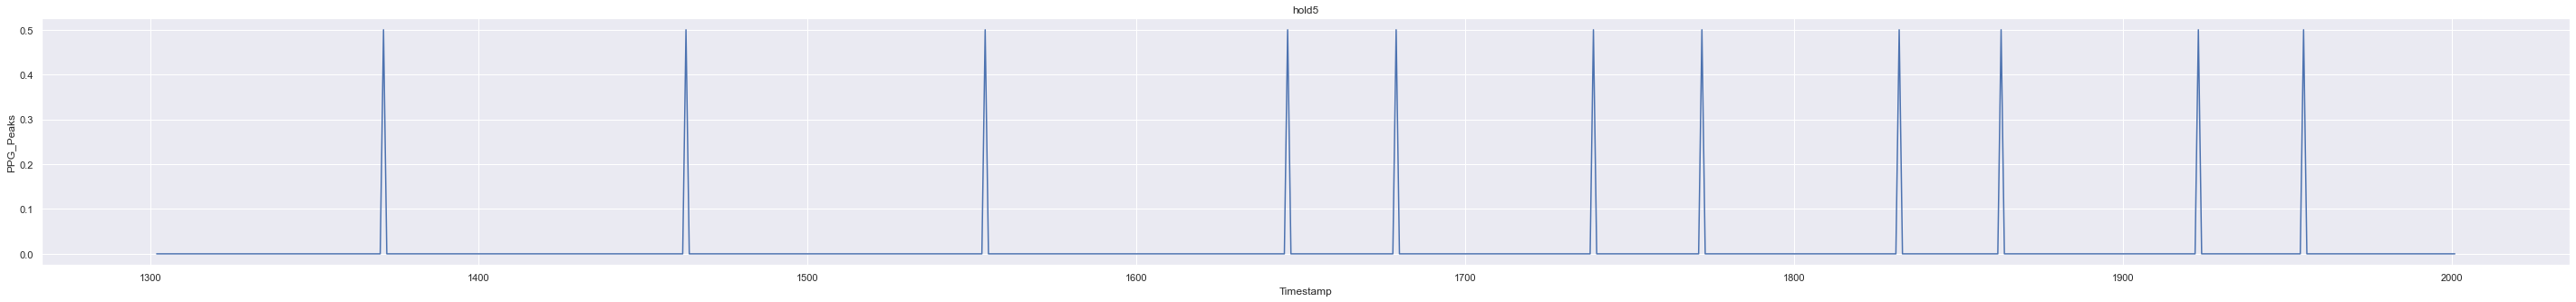

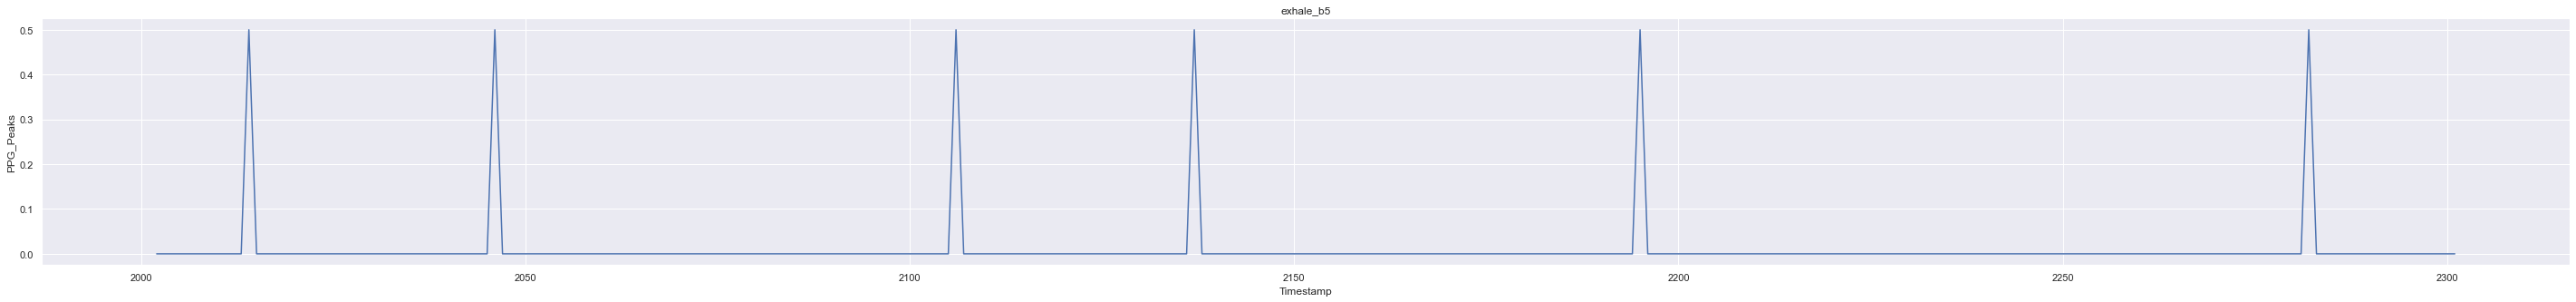

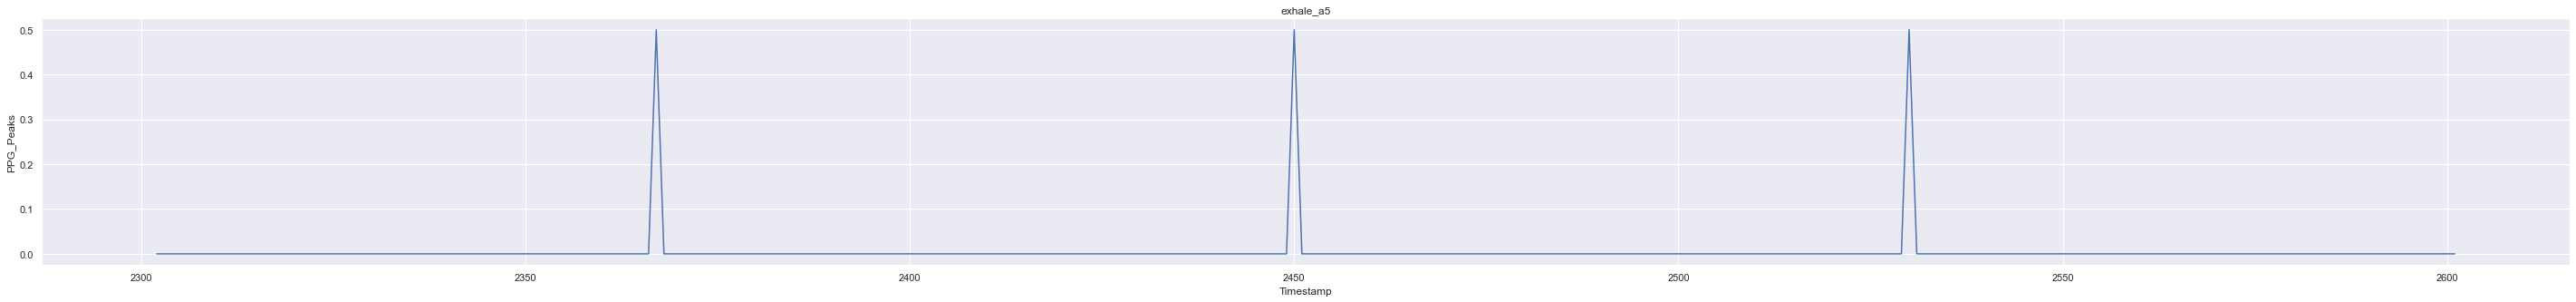

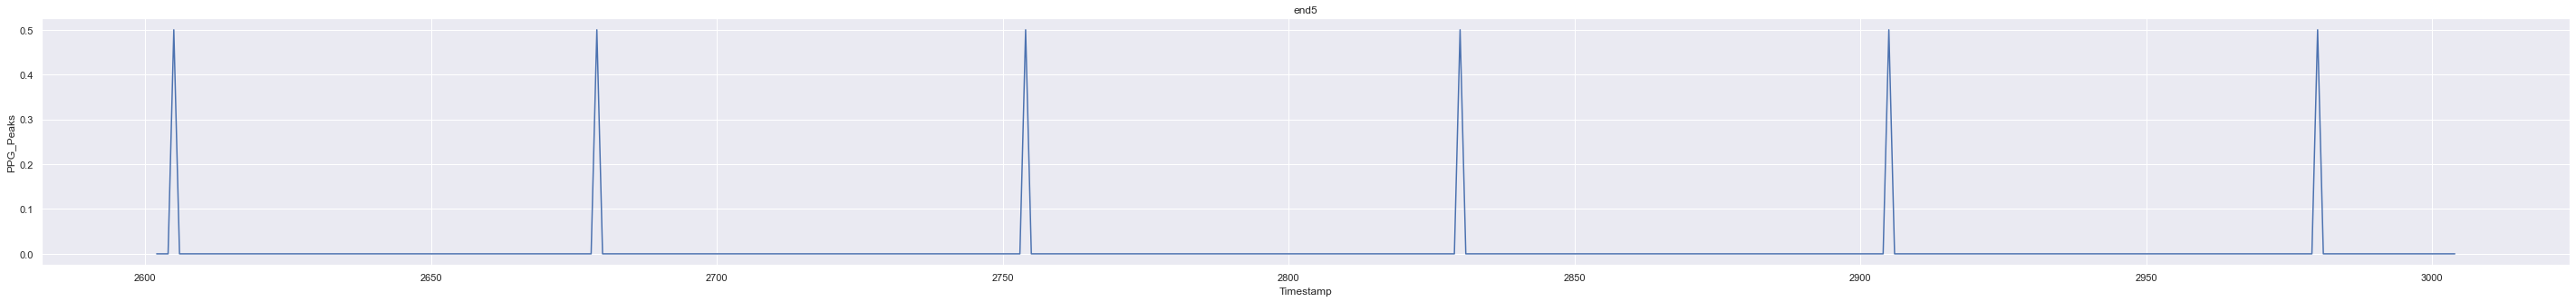

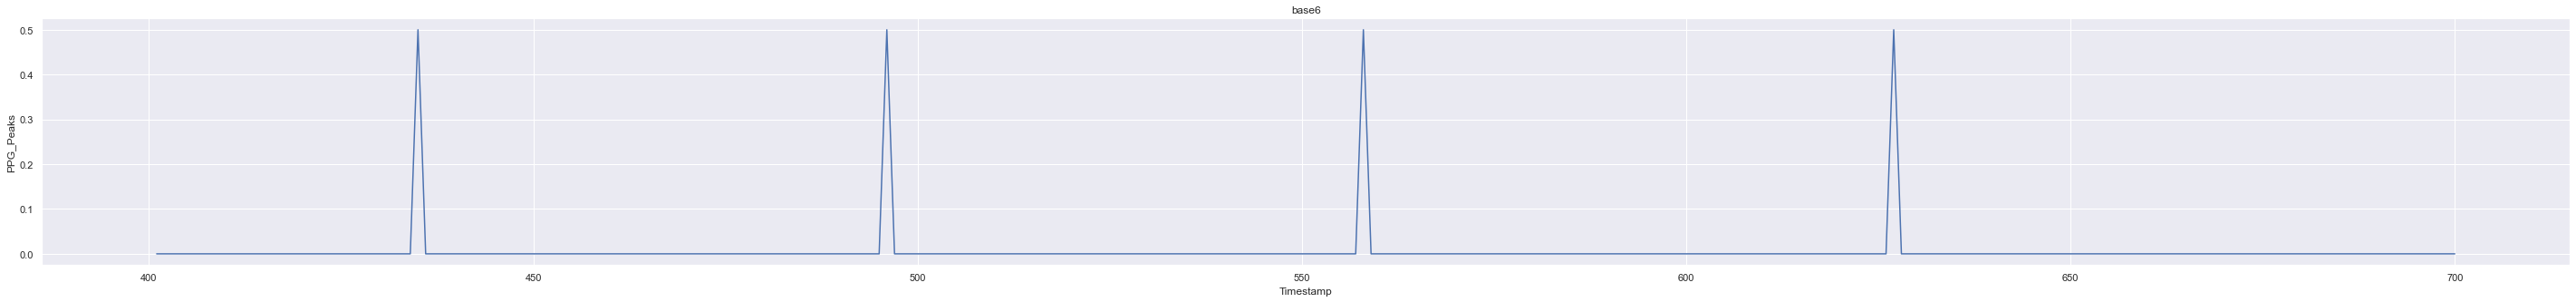

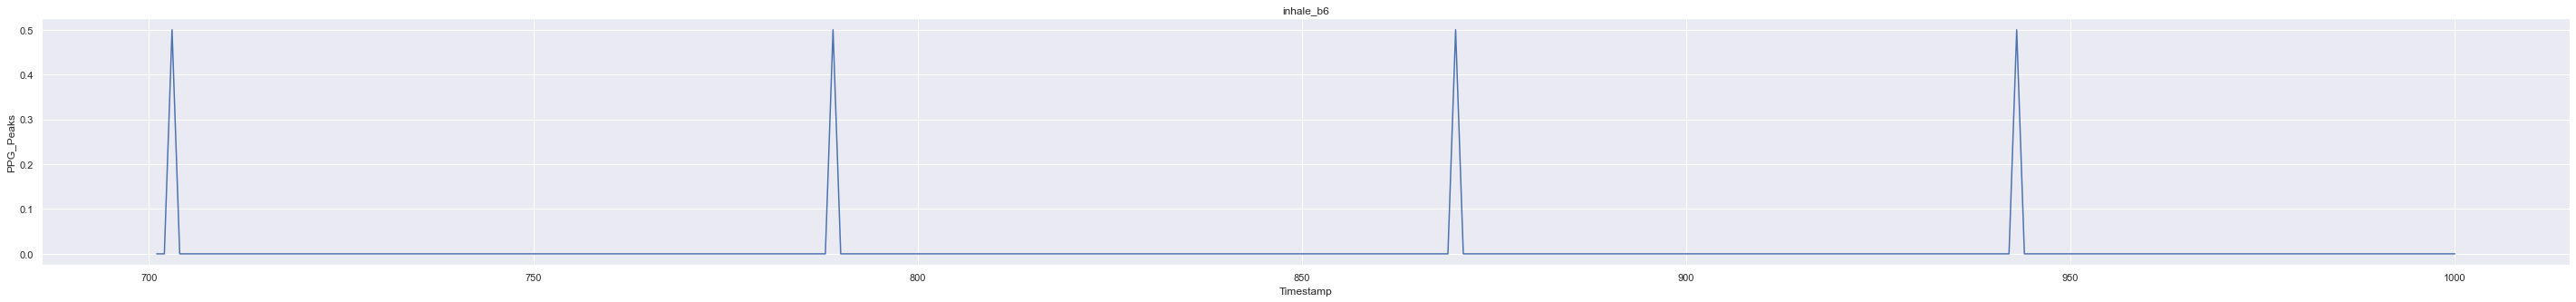

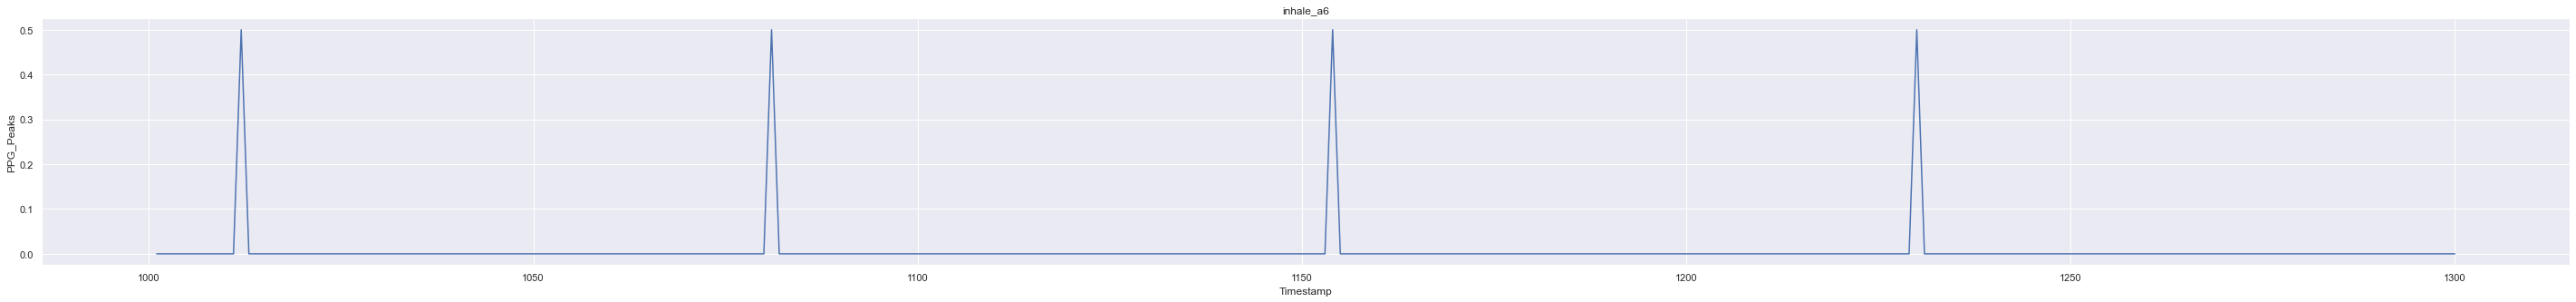

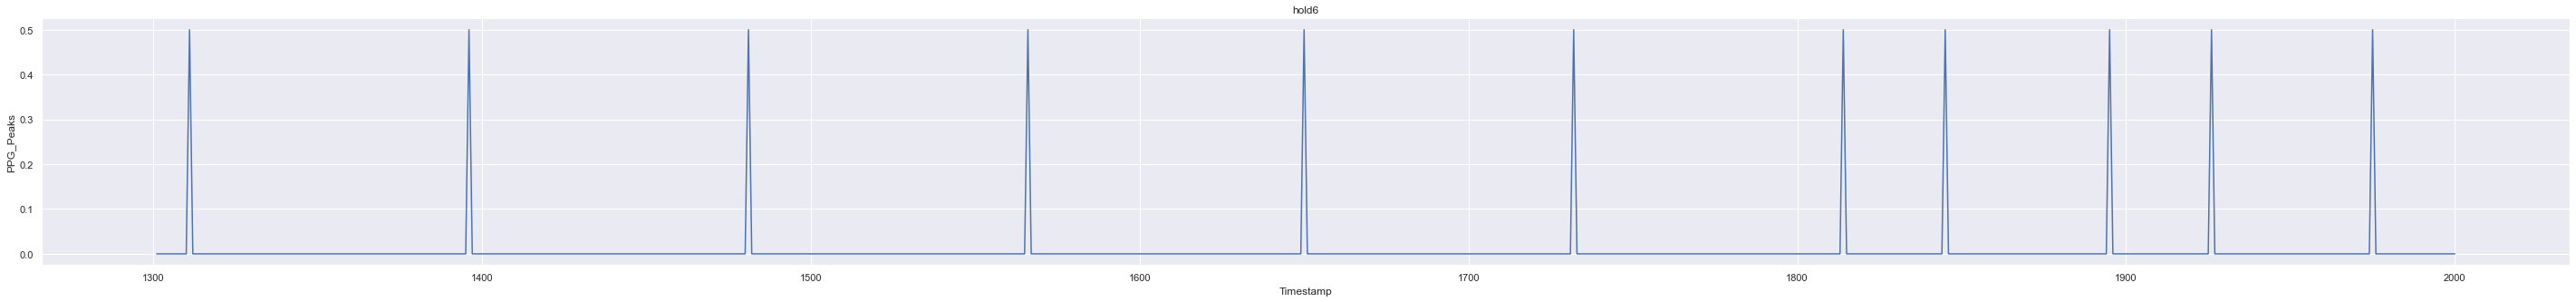

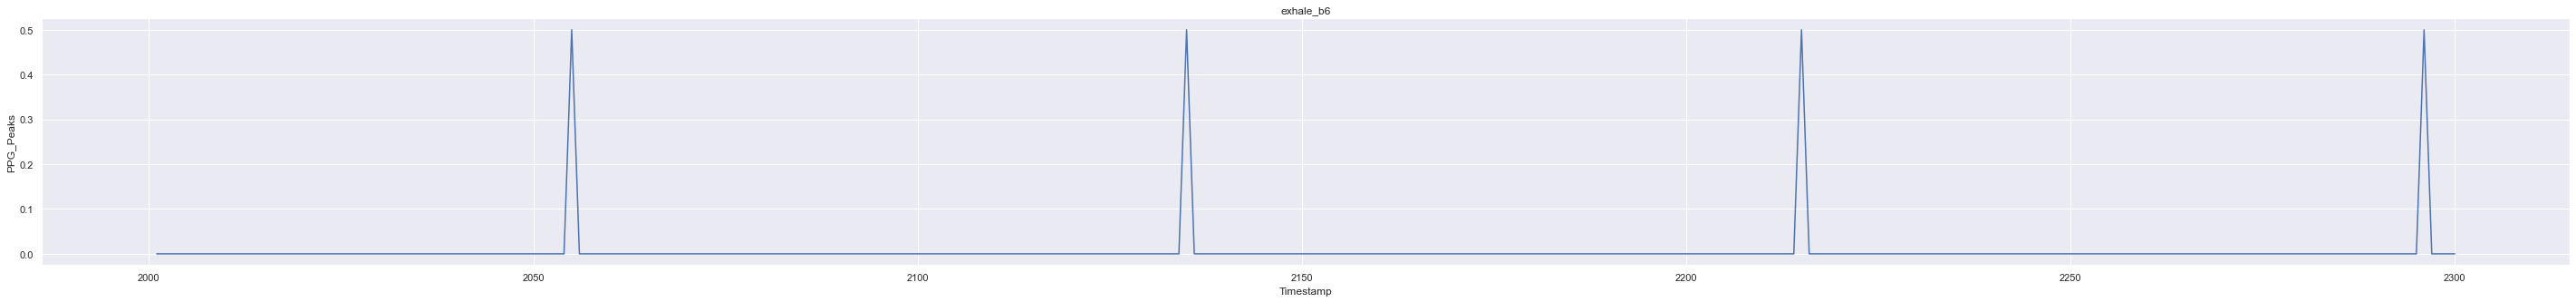

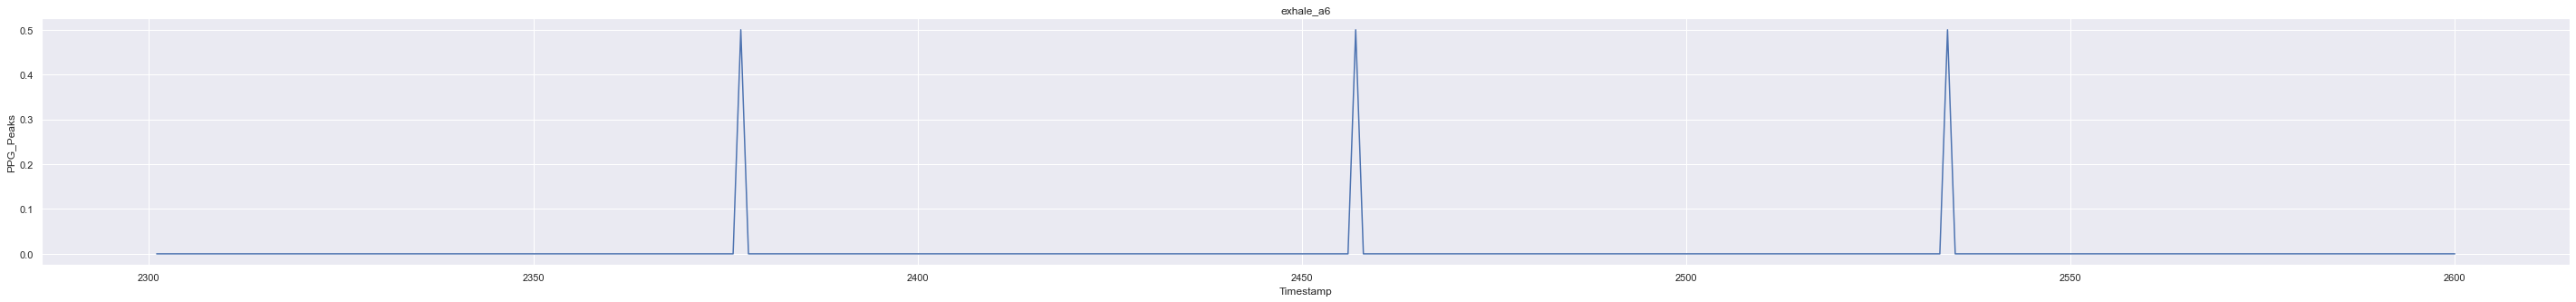

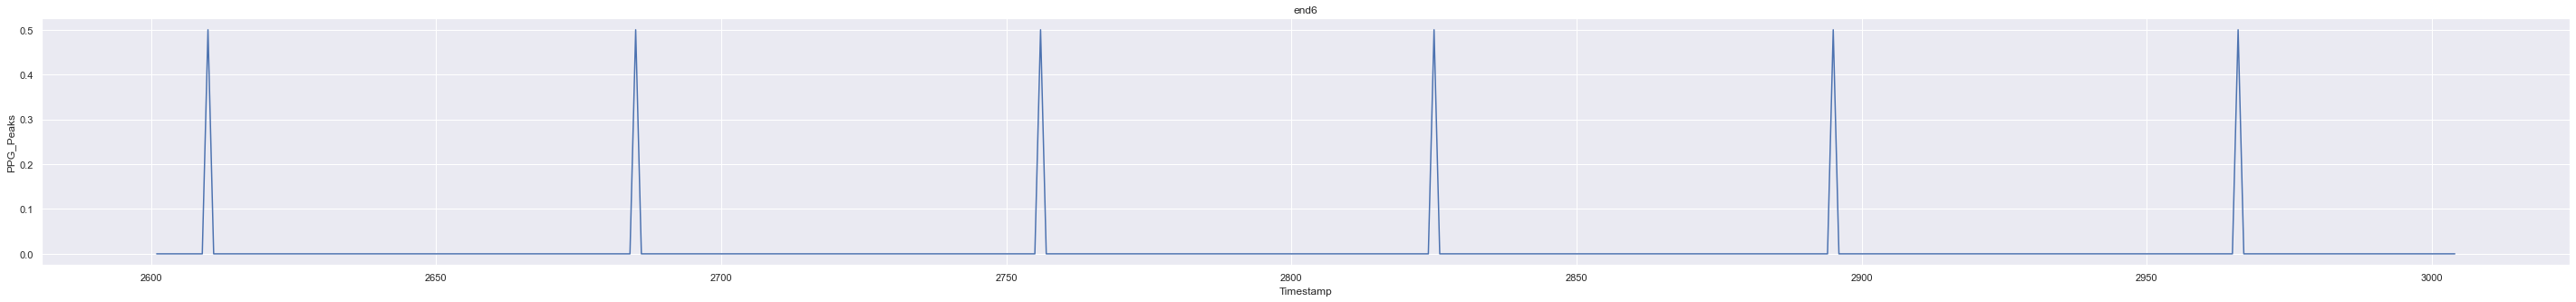

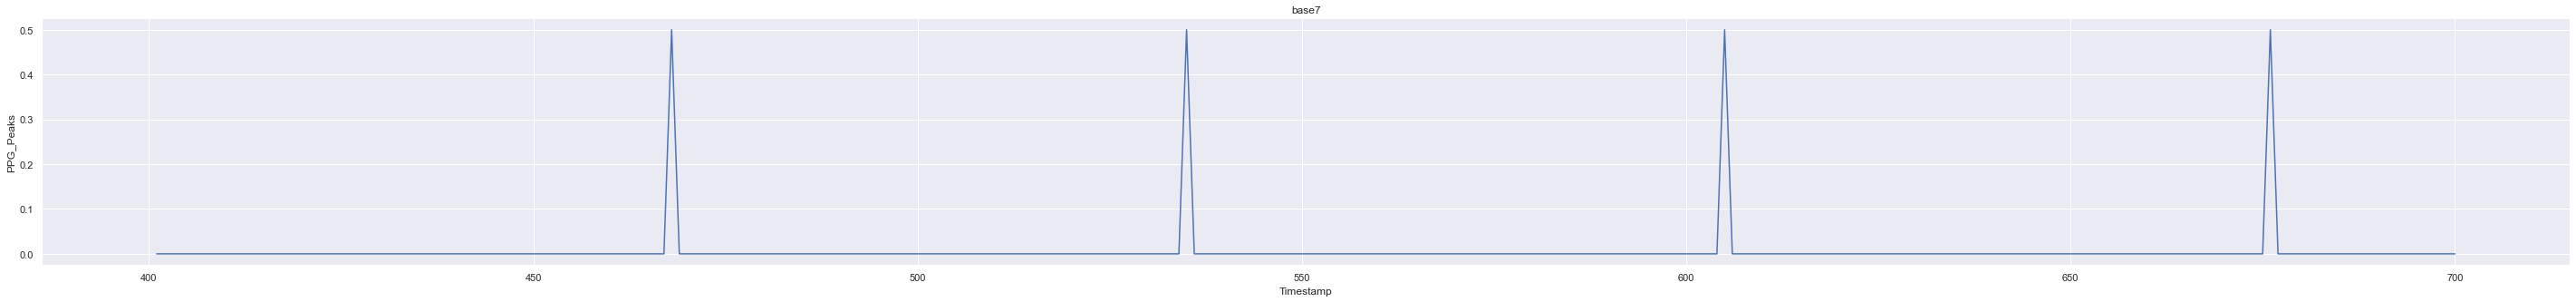

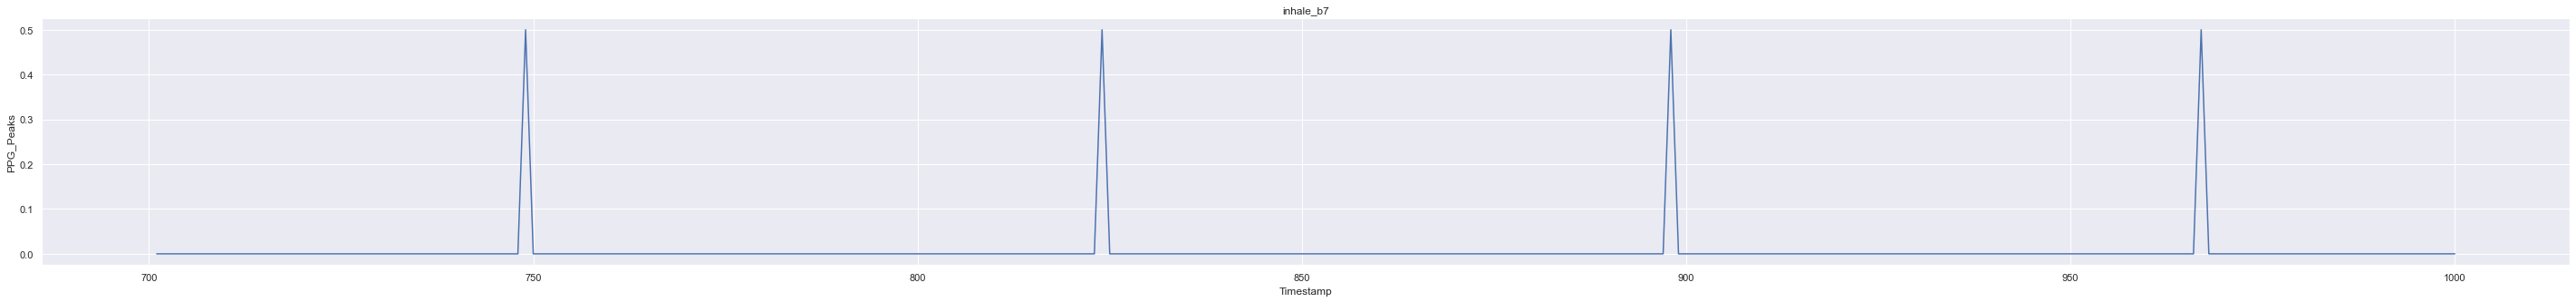

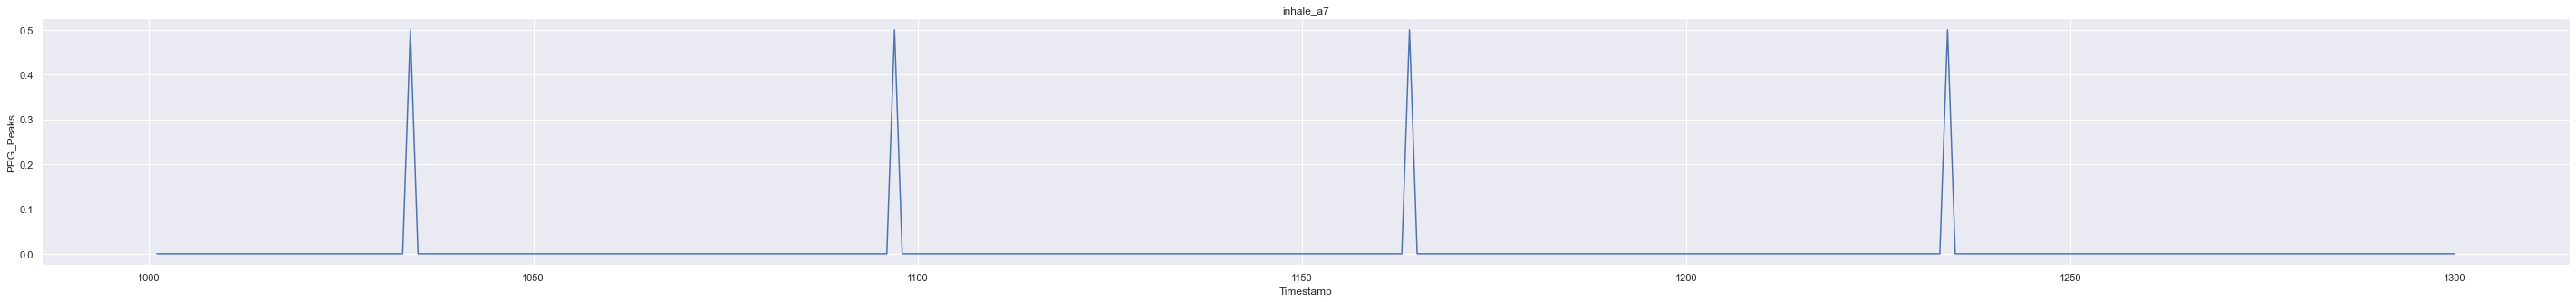

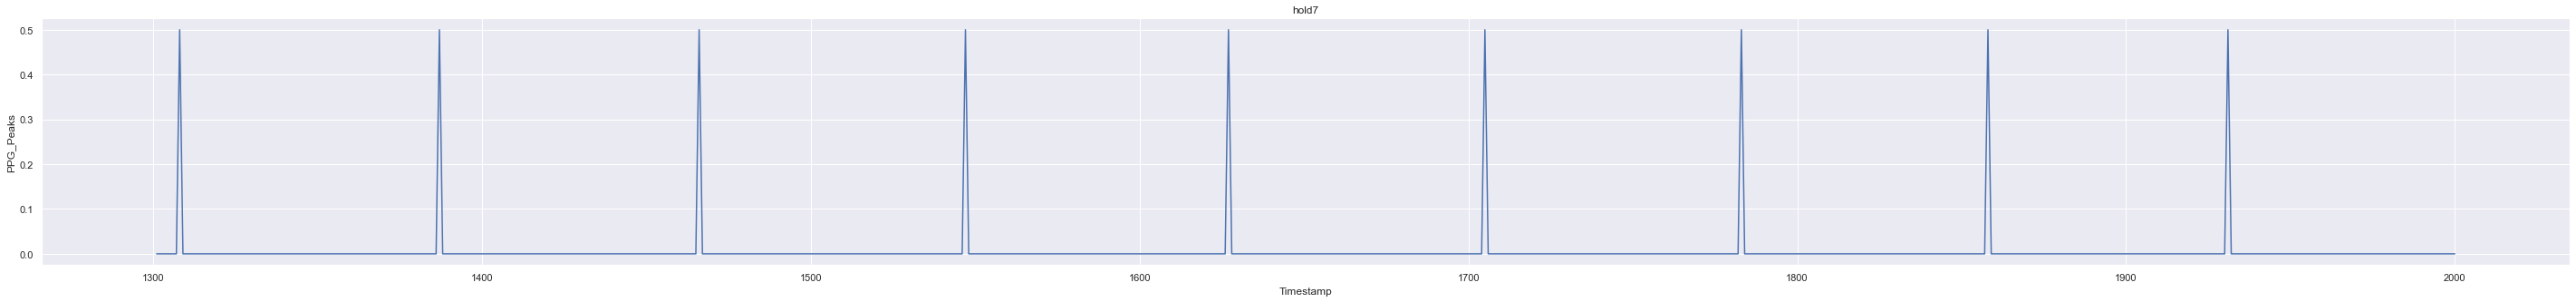

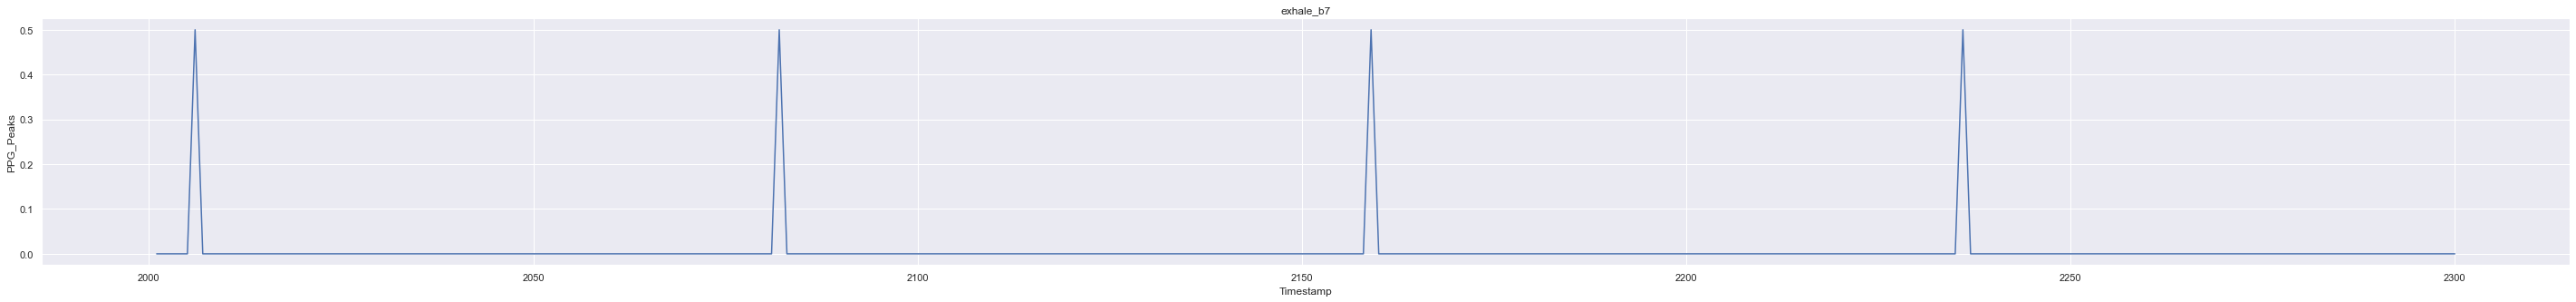

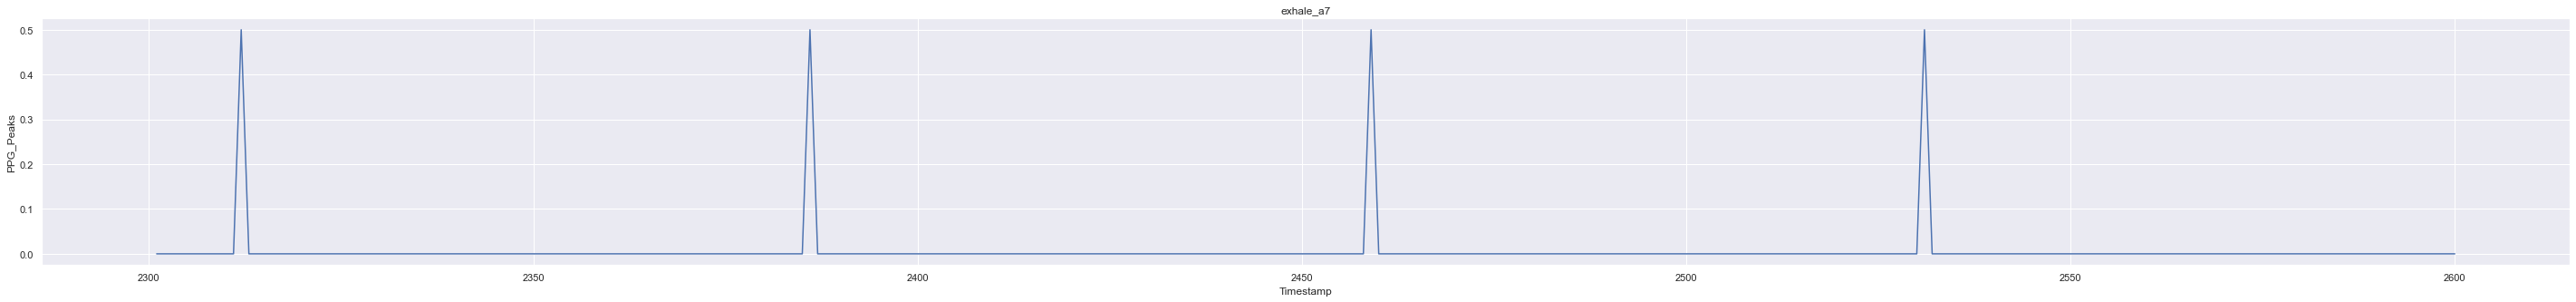

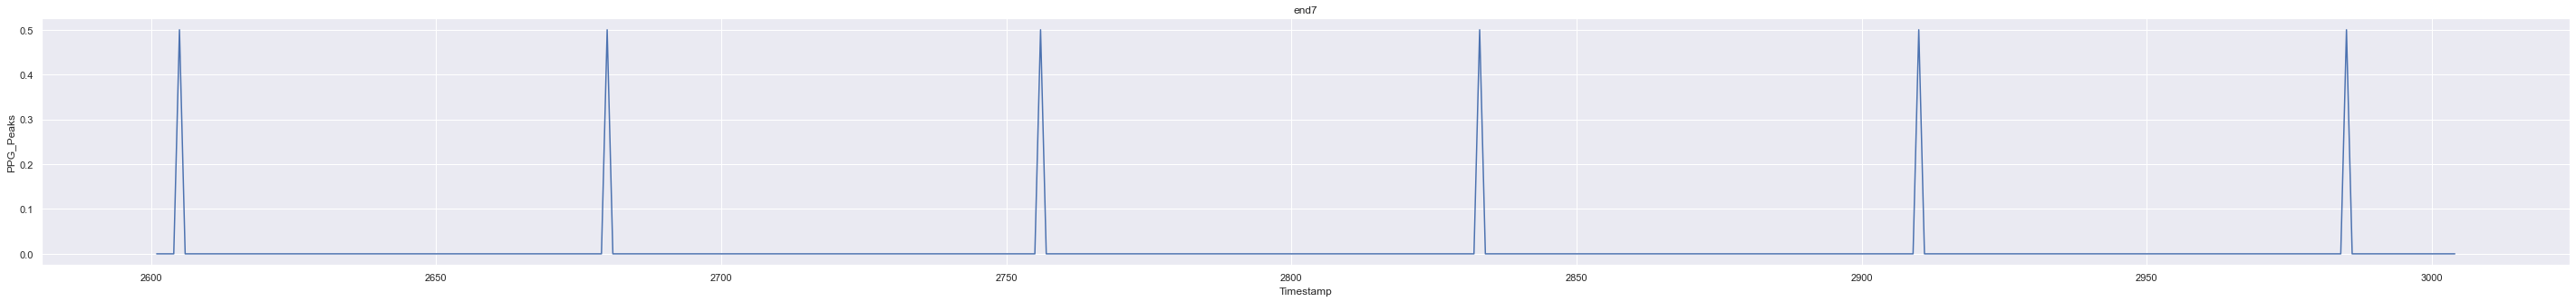

In [128]:
hrvs = {}
for k, v in epochs.items():
    if "end" in k:
        v = v[v['Timestamp']!=0]
    plt.figure(figsize=(50,5))
    plt.title(f"{k}")
    sns.lineplot(data=v, x='Timestamp', y= 'PPG_Peaks')

In [119]:
v['Timestamp'].unique()

array([2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411,
       2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422,
       2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433,
       2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444,
       2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455,
       2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466,
       2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477,
       2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488,
       2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499,
       2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510,
       2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521,
       2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532,
       2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543,
       2544, 2545, 2546, 2547, 2548, 2549, 2550, 25

In [116]:
v

index  Timestamp    EDA_Raw  EDA_Clean  EDA_Tonic  EDA_Phasic  \
0.000000      0          1  86.278717  86.268921  87.973386   -1.704465   
0.001001      1          2  86.467560  86.500626  87.259825   -0.759199   
0.002003      2          3  86.499229  86.504660  87.265873   -0.761213   
0.003004      3          4  86.517227  86.509217  87.271943   -0.762726   
0.004006      4          5  86.499229  86.514523  87.278036   -0.763513   
...         ...        ...        ...        ...        ...         ...   
0.695994    695        696  93.012115  92.997998  90.310038    2.687959   
0.696996    696        697  92.956787  93.004564  90.292157    2.712407   
0.697997    697        698  93.036285  93.010873  90.274122    2.736750   
0.698999    698        699  93.031372  93.016892  90.255934    2.760958   
0.700000    699        700  93.015099  93.022561  90.237591    2.784969   

          SCR_Onsets  SCR_Peaks  SCR_Height  SCR_Amplitude  ...  SCR_Recovery  \
0.000000         0.0        0.0         0.0            0.0  ...           0.0   
0.001001         0.0        0.0         0.0            0.0  ...           0.0   
0.002003         0.0        0.0         0.0            0.0  ...           0.0   
0.003004         0.0        0.0         0.0            0.0  ...           0.0   
0.004006         0.0        0.0         0.0            0.0  ...           0.0   
...              ...        ...         ...            ...  ...           ...   
0.695994         0.0        0.0         0.0            0.0  ...           0.0   
0.696996         0.0        0.0         0.0            0.0  ...           0.0   
0.697997         0.0        0.0         0.0            0.0  ...           0.0   
0.698999         0.0        0.0         0.0            0.0  ...           0.0   
0.700000         0.0        0.0         0.0            0.0  ...           0.0   

          SCR_RecoveryTime      PPG_Raw   PPG_Clean   PPG_Rate  PPG_Peaks  \
0.000000               0.0  1601.968262  104.790281  39.848481        0.0   
0.001001               0.0  1435.991211  -36.718870  41.220570        0.0   
0.002003               0.0  1435.978638  -37.599460  41.220570        0.0   
0.003004               0.0  1438.239258  -38.459668  41.220570        0.0   
0.004006               0.0  1441.725952  -39.180322  41.220570        0.0   
...                    ...          ...         ...        ...        ...   
0.695994               0.0  1490.935303  -26.256506  38.996231        0.0   
0.696996               0.0  1478.143799  -40.012918  38.978439        0.0   
0.697997               0.0  1464.136353  -51.169664  38.960677        0.0   
0.698999               0.0  1453.894775  -59.499661  38.942946        0.0   
0.700000               0.0  1448.615479  -64.716139  38.925249        0.0   

           Scene Trial Index  Label  
0.000000  breath     1     0  base1  
0.001001  breath     1     1  base1  
0.002003  breath     1     2  base1  
0.003004  breath     1     3  base1  
0.004006  breath     1     4  base1  
...          ...   ...   ...    ...  
0.695994  breath     1   695  base1  
0.696996  breath     1   696  base1  
0.697997  breath     1   697  base1  
0.698999  breath     1   698  base1  
0.700000  breath     1   699  base1  

[700 rows x 21 columns]

In [113]:
peaks

(     PPG_Peaks
 0            0
 1            0
 2            0
 3            0
 4            0
 ..         ...
 695          0
 696          0
 697          0
 698          0
 699          0
 
 [700 rows x 1 columns],
 {'method_peaks': 'elgendi',
  'method_fixpeaks': 'None',
  'PPG_Peaks': array([], dtype=int32),
  'sampling_rate': 100})

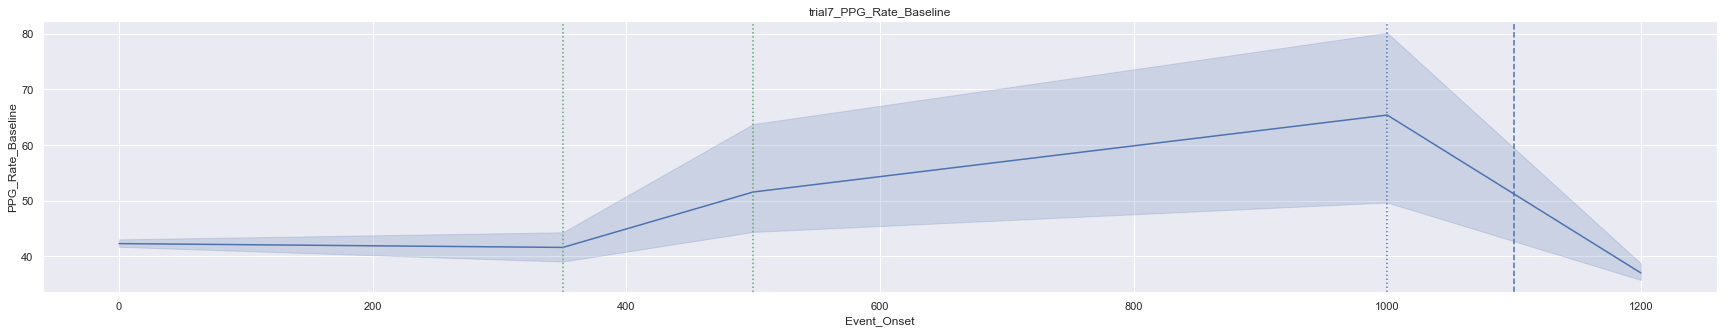

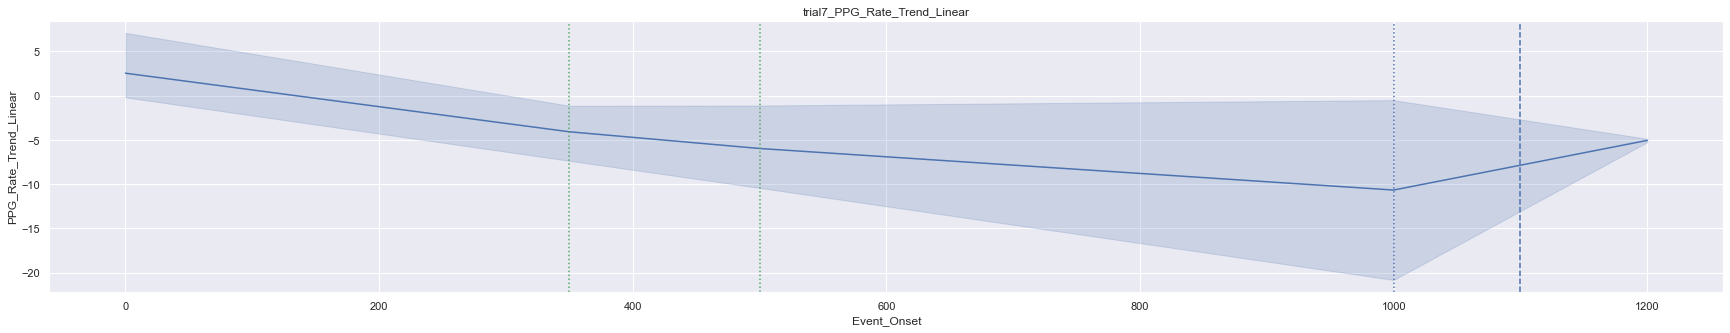

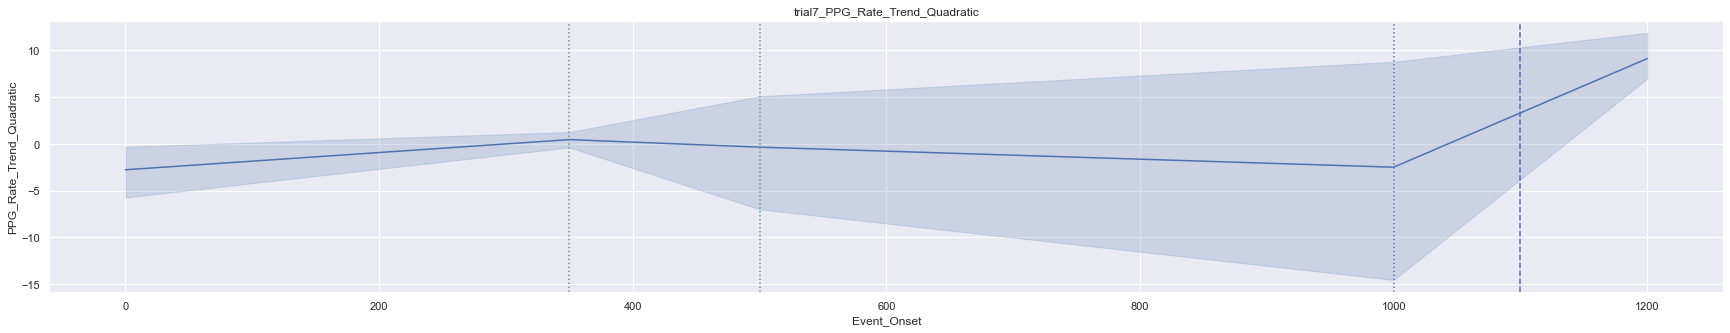

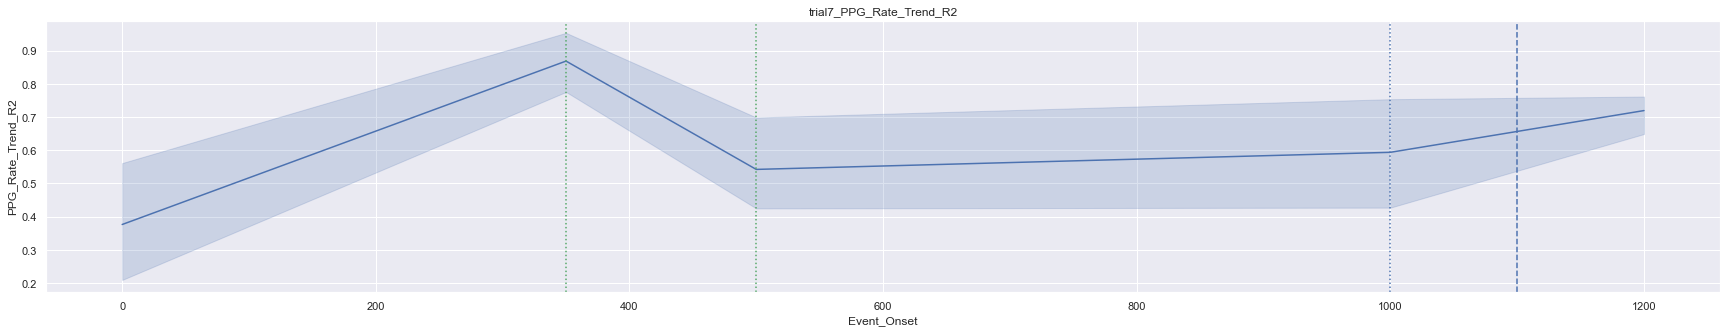

In [60]:
lst = ['PPG_Rate_Baseline', 'PPG_Rate_Trend_Linear', 'PPG_Rate_Trend_Quadratic','PPG_Rate_Trend_R2']
# for data in tests:
#     df = data.reset_index().copy()
#     trial = data['Trial'][0]
#     lst_s = list(df[df['Timestamp']==1].index)
for item in lst:
    plt.figure(figsize=(30,5))
    plt.title(f'trial{trial}_{item}')
    sns.lineplot(data = ppg_breath, x='Event_Onset', y=item )
    plt.axvline(350, color='g', linestyle=':') ## Start to take a deep breath(7sec point)
    plt.axvline(500, color='g', linestyle=':')## Hold breath start 10sec point
    plt.axvline(1000, color='b', linestyle=':')## Release breath 20 sec point
    plt.axvline(1100, color='b', linestyle='--')## Release breath 22 sec point
    
    
    # for item in lst_s:
    #     plt.axvline(item, color='r', linestyle='--')

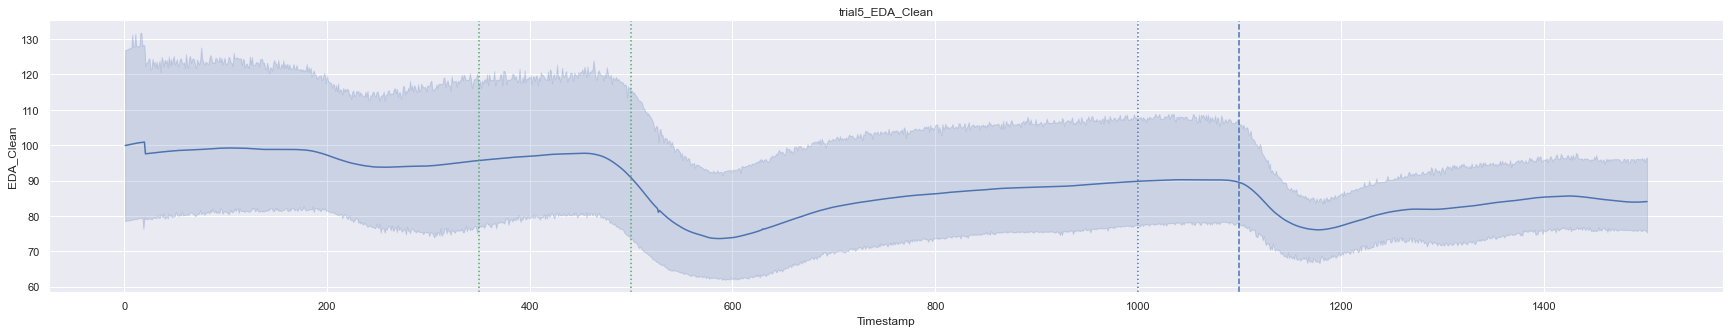

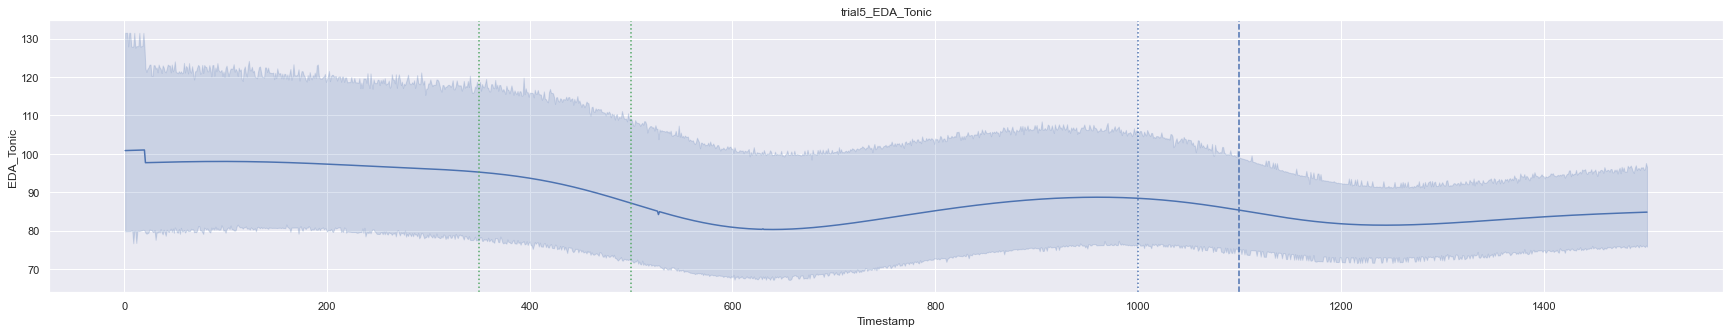

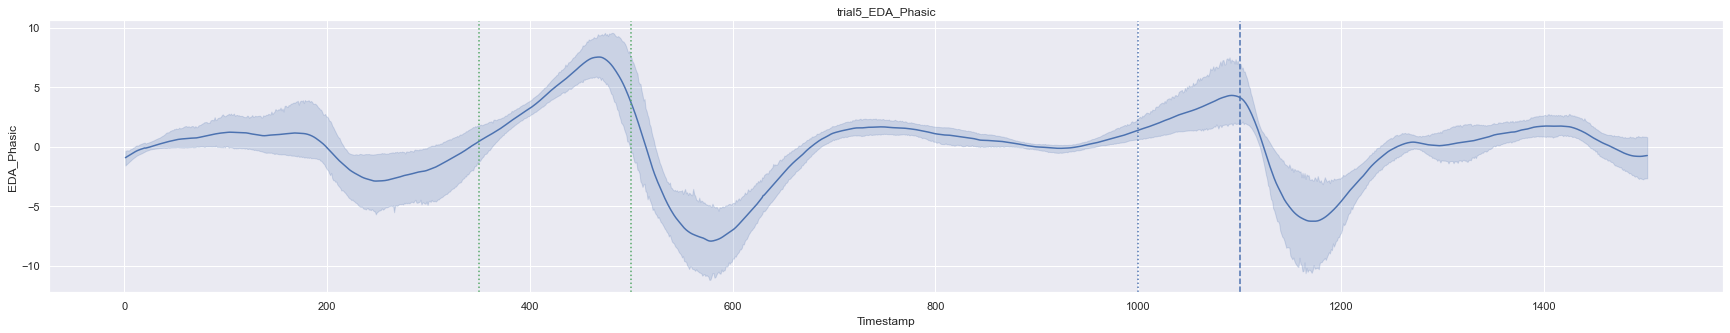

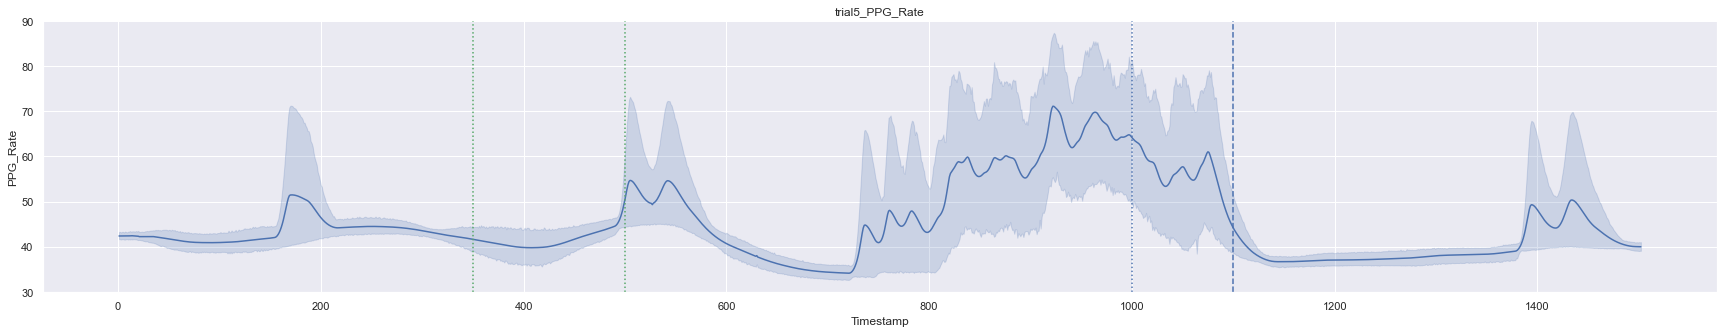

In [14]:
lst = ['EDA_Clean', 'EDA_Tonic', 'EDA_Phasic','PPG_Rate']
# for data in tests:
#     df = data.reset_index().copy()
#     trial = data['Trial'][0]
#     lst_s = list(df[df['Timestamp']==1].index)
for item in lst:
    plt.figure(figsize=(30,5))
    plt.title(f'trial{trial}_{item}')
    sns.lineplot(data = total_df[total_df['Scene']=='breath'], x='Timestamp', y=item )
    plt.axvline(350, color='g', linestyle=':') ## Start to take a deep breath(7sec point)
    plt.axvline(500, color='g', linestyle=':')## Hold breath start 10sec point
    plt.axvline(1000, color='b', linestyle=':')## Release breath 20 sec point
    plt.axvline(1100, color='b', linestyle='--')## Release breath 22 sec point
    
    
    # for item in lst_s:
    #     plt.axvline(item, color='r', linestyle='--')

In [ ]:
lst = ['EDA_Clean', 'EDA_Tonic', 'EDA_Phasic','PPG_Rate']
for data in tests:
    df = data.reset_index().copy()
    trial = data['Trial'][0]
    lst_s = list(df[df['Timestamp']==1].index)
    for item in lst:
        plt.figure(figsize=(30,5))
        plt.title(f'trial{trial}_{item}')
        sns.lineplot(data = df, x='index', y=item )
        plt.axvline(350, color='g', linestyle=':') ## Start to take a deep breath(7sec point)
        plt.axvline(500, color='g', linestyle=':')## Hold breath start 10sec point
        plt.axvline(1000, color='b', linestyle=':')## Release breath 20 sec point
        plt.axvline(1100, color='b', linestyle='--')## Release breath 22 sec point
        
        
        for item in lst_s:
            plt.axvline(item, color='r', linestyle='--')

In [6]:
pointlst = total_df[total_df['index']==1000].index
df_cut = pd.DataFrame()
for i in pointlst:
    _df = total_df.loc[i-200:i+200]
    df_cut = pd.concat((df_cut,_df))
df_cut  = df_cut.reset_index(drop=True)

In [ ]:
pointlst = total_df[total_df['index']==1000].index
df_b = pd.DataFrame()
for i in pointlst:
    _df = total_df.loc[i-200:i+200]
    df_b = pd.concat((df_cut,_df))
df_b  = df_b.reset_index(drop=True)

In [10]:
df = df_cut["PPG_Raw", "PPG_Clean", "PPG_Rate", "PPG_Peaks", "Trial"]

index  Timestamp    EDA_Raw  EDA_Clean  EDA_Tonic  EDA_Phasic  \
0       800        801  87.354225  87.363017  85.741755    1.621262   
1       801        802  87.435043  87.423629  85.800585    1.623043   
2       802        803  87.489334  87.486022  85.859105    1.626917   
3       803        804  87.547981  87.545452  85.917312    1.628140   
4       804        805  87.602509  87.598798  85.975204    1.623594   
...     ...        ...        ...        ...        ...         ...   
2401   1196       1197  60.823208  60.839306  64.817504   -3.978198   
2402   1197       1198  60.986801  60.986576  64.808222   -3.821646   
2403   1198       1199  61.151253  61.132200  64.799397   -3.667197   
2404   1199       1200  61.291962  61.275293  64.791025   -3.515731   
2405   1200       1201  61.403988  61.416635  64.783104   -3.366468   

      SCR_Onsets  SCR_Peaks  SCR_Height  SCR_Amplitude  SCR_RiseTime  \
0            0.0        0.0         0.0            0.0           0.0   
1            0.0        0.0         0.0            0.0           0.0   
2            0.0        0.0         0.0            0.0           0.0   
3            0.0        0.0         0.0            0.0           0.0   
4            0.0        0.0         0.0            0.0           0.0   
...          ...        ...         ...            ...           ...   
2401         0.0        0.0         0.0            0.0           0.0   
2402         0.0        0.0         0.0            0.0           0.0   
2403         0.0        0.0         0.0            0.0           0.0   
2404         0.0        0.0         0.0            0.0           0.0   
2405         0.0        0.0         0.0            0.0           0.0   

      SCR_Recovery  SCR_RecoveryTime      PPG_Raw   PPG_Clean   PPG_Rate  \
0              0.0               0.0  1475.157593  -46.710888  33.993106   
1              0.0               0.0  1514.579346   -8.929366  34.010782   
2              0.0               0.0  1582.764893   55.438146  34.029130   
3              0.0               0.0  1655.683594  127.343701  34.048163   
4              0.0               0.0  1713.629883  183.721133  34.067892   
...            ...               ...          ...         ...        ...   
2401           0.0               0.0  1596.348145   62.320172  40.865293   
2402           0.0               0.0  1542.224609    8.601294  40.875854   
2403           0.0               0.0  1500.188354  -32.572743  40.885949   
2404           0.0               0.0  1470.274414  -60.798497  40.895604   
2405           0.0               0.0  1453.404785  -76.528254  40.904841   

      PPG_Peaks   Scene Trial  
0           0.0  breath     1  
1           0.0  breath     1  
2           0.0  breath     1  
3           0.0  breath     1  
4           0.0  breath     1  
...         ...     ...   ...  
2401        0.0  breath     7  
2402        0.0  breath     7  
2403        0.0  breath     7  
2404        0.0  breath     7  
2405        0.0  breath     7  

[2406 rows x 19 columns]

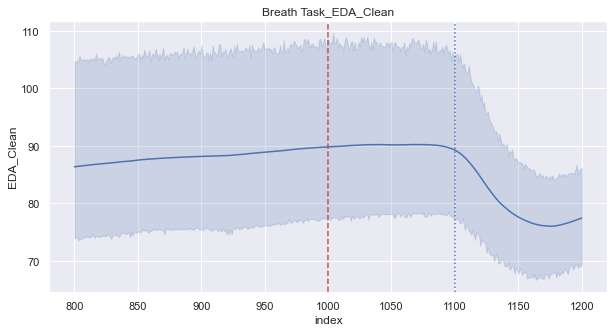

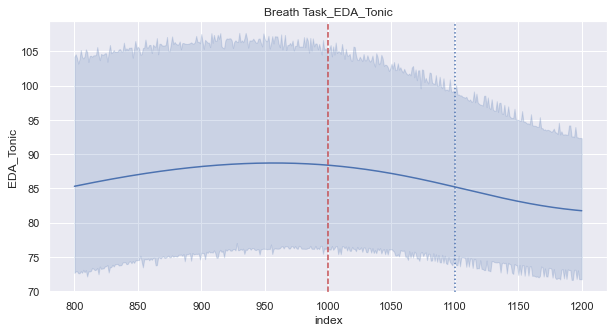

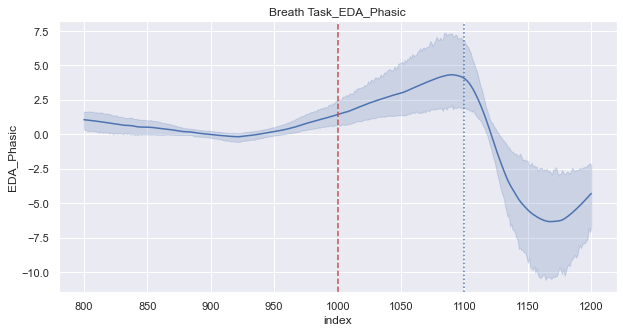

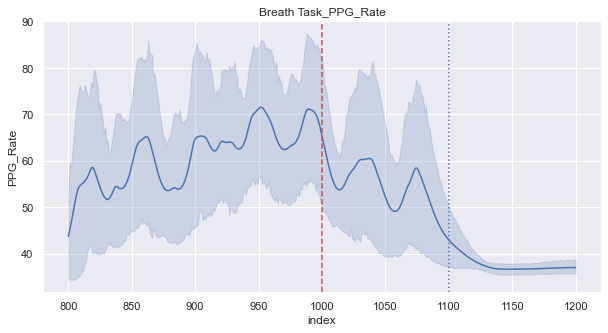

In [8]:
lst = ['EDA_Clean', 'EDA_Tonic', 'EDA_Phasic','PPG_Rate']

for item in lst:    
    plt.figure(figsize=(10,5))
    plt.title(f'Breath Task_{item}')
    sns.lineplot(data = df_cut, x='index', y=item )
    plt.axvline(1000, color='r', linestyle='--')
    plt.axvline(1100, color='b', linestyle=':')
    
    

In [167]:
total_df.columns

Index(['index', 'Timestamp', 'EDA_Raw', 'EDA_Clean', 'EDA_Tonic', 'EDA_Phasic',
       'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
       'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime', 'PPG_Raw',
       'PPG_Clean', 'PPG_Rate', 'PPG_Peaks', 'Scene', 'Trial'],
      dtype='object')

In [172]:
meanval = total_df.groupby(['Trial','Scene'])[['EDA_Raw', 'EDA_Clean', 'EDA_Tonic', 'EDA_Phasic',
       'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
       'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime', 'PPG_Raw',
       'PPG_Clean', 'PPG_Rate', 'PPG_Peaks']].mean()
meanval = meanval.reset_index()

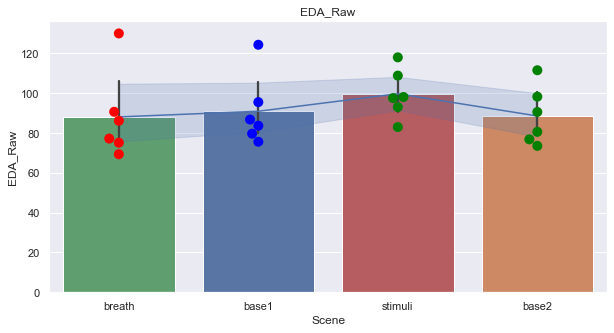

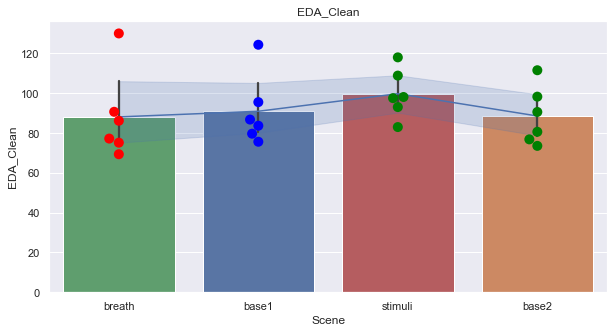

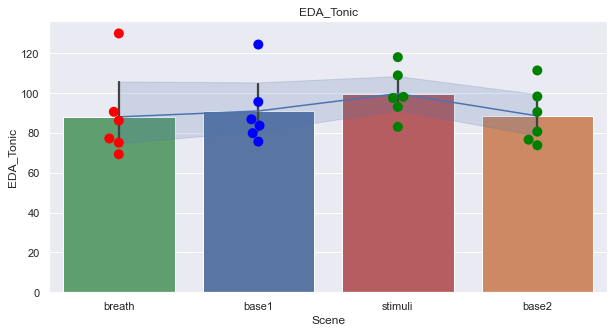

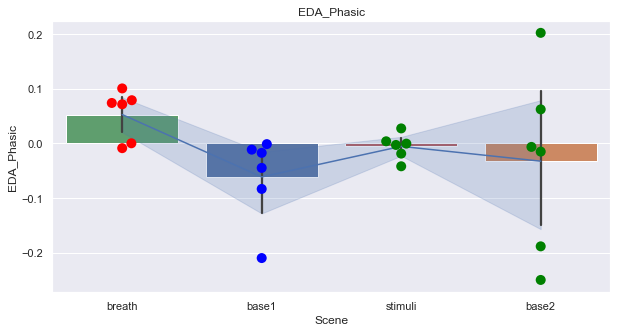

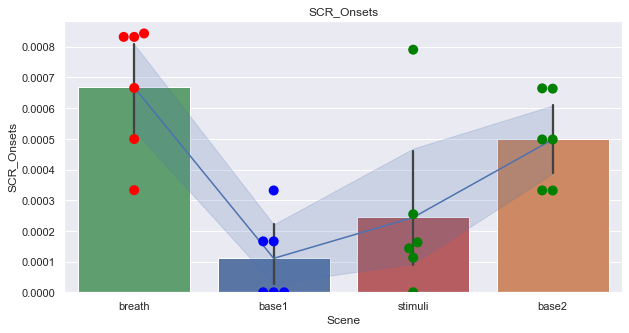

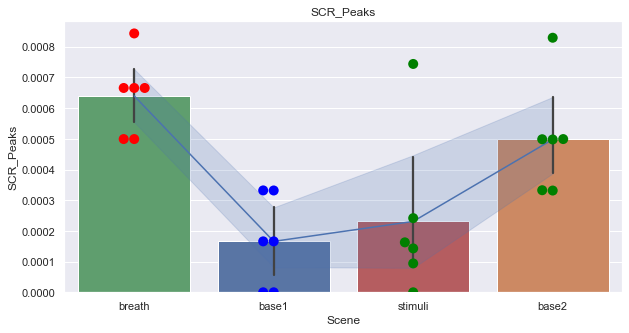

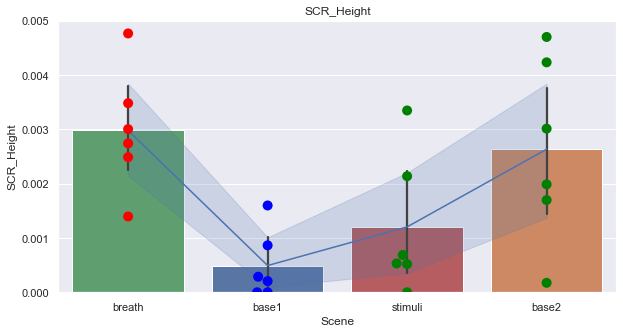

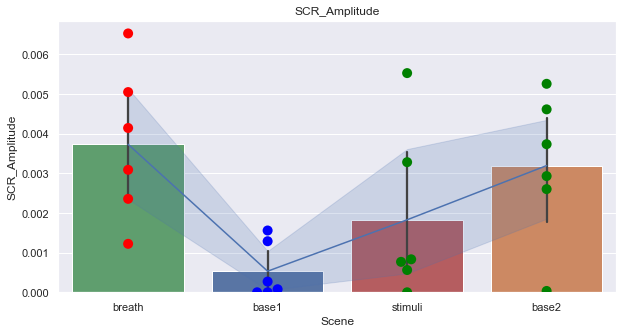

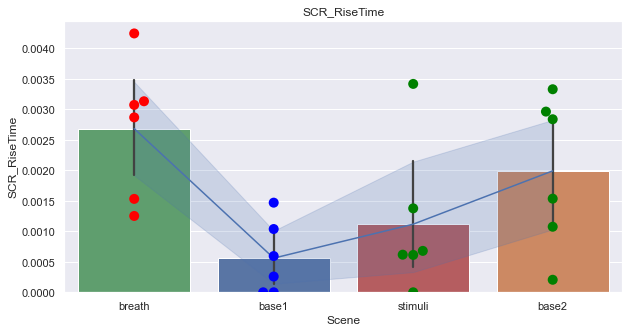

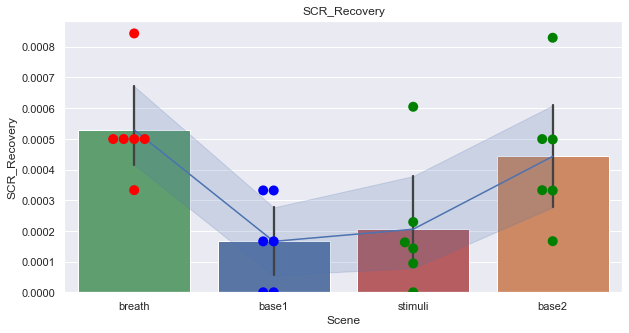

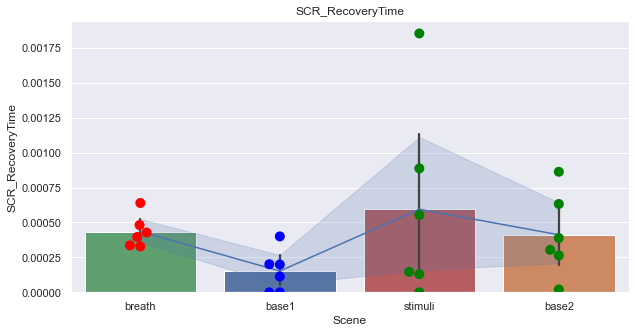

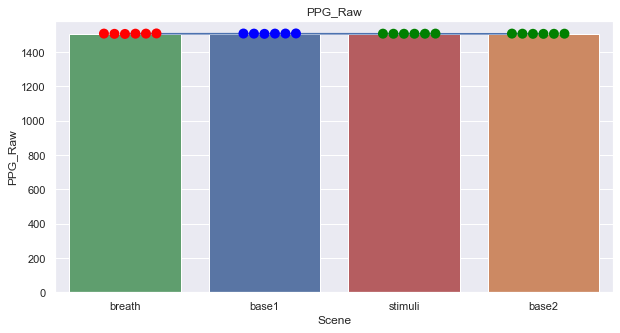

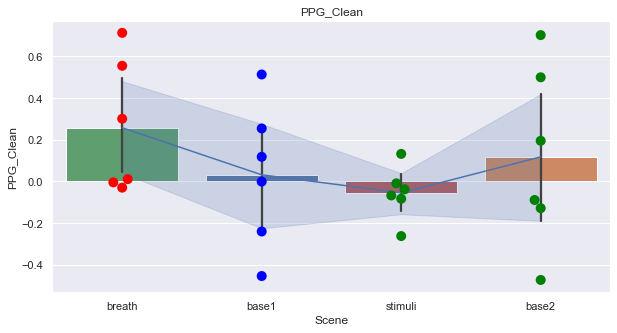

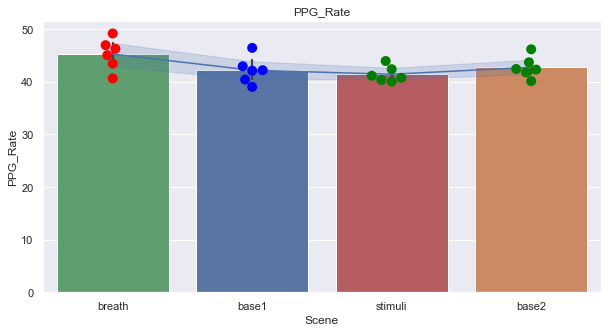

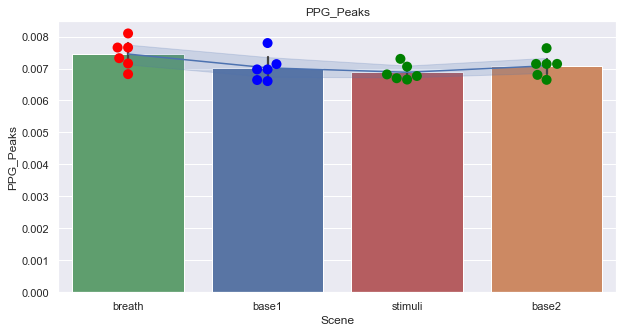

In [177]:
lst = ['EDA_Raw', 'EDA_Clean', 'EDA_Tonic', 'EDA_Phasic',
       'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
       'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime', 'PPG_Raw',
       'PPG_Clean', 'PPG_Rate', 'PPG_Peaks']

for item in lst:
    plt.figure(figsize=(10,5))
    plt.title(f'{item}')
    sns.barplot(x='Scene', y=item, hue='Scene',data= meanval, order=["breath", "base1", "stimuli", "base2"])
    sns.lineplot(x='Scene', y=item,data= meanval)
    sns.swarmplot(x='Scene', y=item, hue='Scene',data= meanval, s=10, palette=["blue","green", "red","green"])
    